In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackathon-qualification/Starter Notebook.ipynb
/kaggle/input/hackathon-qualification/archive/sample_submission.csv
/kaggle/input/hackathon-qualification/archive/train.csv
/kaggle/input/hackathon-qualification/archive/test.csv
/kaggle/input/cleaned-dsn-data/train_clean.csv
/kaggle/input/cleaned-dsn-data/car_data_cleaning_log.json
/kaggle/input/cleaned-dsn-data/test_clean.csv
/kaggle/input/cleaned-dsn-data/my_custom_cleaning_log.json


In [2]:
!pip install lightgbm
!pip install catboost

In [3]:
# Core Python
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Improve display formatting in pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # Avoid scientific notation
pd.set_option('display.max_rows', None)                      # Show all DataFrame rows
pd.set_option('display.max_columns', None)                   # Show all DataFrame columns
pd.set_option('display.width', None)                         # Disable line wrapping
pd.set_option('display.max_colwidth', None)                  # Show full content in cells


from scipy.optimize import minimize_scalar
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from catboost import CatBoostRegressor

In [4]:
def load_and_describe_data(file_paths):
    """
    Load and describe multiple CSV datasets.

    Parameters:
    file_paths (dict): Dictionary where keys are dataset names and values are file paths.

    Returns:
    dict: Dictionary of loaded DataFrames {name: DataFrame}
    """

    datasets = {}

    for name, path in file_paths.items():
        try:
            df = pd.read_csv(path)
            datasets[name] = df

            print(f"\n{'='*70}")
            print(f"📂 Dataset: {name}")
            print(f"File: {path}")
            print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
            print(f"{'='*70}\n")

            print("🔍 First 5 rows:")
            display(df.head())

            print("\nℹ️ Info:")
            df.info()  # already prints, no need for display()

            print("\n📊 Missing Values:")
            missing = df.isnull().sum()
            missing = missing[missing > 0].sort_values(ascending=False)
            if not missing.empty:
                print(missing)
            else:
                print("No missing values detected.")

            print("\n✅ Data Types:")
            print(df.dtypes.value_counts())
            print("\n" + "-"*70 + "\n")

        except Exception as e:
            print(f"❌ Error loading {name} ({path}): {e}")

    return datasets

## Dataset Overview
The project uses three datasets: **Train**, **Test**, and a **Submission Template**.

## Train Dataset
* **File:** `train_clean.csv`
* **Shape:** 188,533 rows × 34 columns
* Contains vehicle information including brand, model, year, mileage, fuel type, engine details, transmission, colors, accident history, title status, and price (target variable).
* **Missing values:** Most notable in `aspiration` (173,891), `drivetrain` (172,735), `trim` (140,743), `config` (104,907), and `num_speeds` (84,286).
* **Target variable:** `price`.

## Test Dataset
* **File:** `test_clean.csv`
* **Shape:** 125,690 rows × 33 columns
* Has the same features as the train set except `price`, which needs to be predicted.
* **Missing values:** Similar trends as the train set, with high gaps in `aspiration` (115,897), `drivetrain` (115,000), and `trim` (94,074).

### Submission Template
* **File:** `sample_submission.csv`
* **Shape:** 125,690 rows × 2 columns (`id`, `price`)
* Serves as the required format for competition submission.

**Summary:**
The datasets provide a wide range of structured attributes describing used cars, but many fields (engine configuration, drivetrain, trim, aspiration) are sparsely populated. Handling these missing values effectively will be crucial in building a strong predictive model.

In [5]:
file_paths = {
    "Train": "/kaggle/input/cleaned-dsn-data/train_clean.csv",
    "Test": "/kaggle/input/cleaned-dsn-data/test_clean.csv",
    "Submission_Template": "/kaggle/input/hackathon-qualification/archive/sample_submission.csv"
}

datasets = load_and_describe_data(file_paths)

# Access a dataset:
train = datasets["Train"]
test = datasets["Test"]
sub = datasets["Submission_Template"]


📂 Dataset: Train
File: /kaggle/input/cleaned-dsn-data/train_clean.csv
Shape: 188533 rows × 34 columns

🔍 First 5 rows:


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,horsepower,engine_liters,cylinders,config,aspiration,extra_descriptors,base_model,trim,body_style,drivetrain,base_color,paint_finish,two_tone,raw_ext_col,base_int_color,material,raw_int_col,transmission_type,num_speeds,has_auto_shift,special_notes,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,172.00,1.60,4.00,NaN,NaN,Cylinder Engine,Cooper,NaN,Hatchback,NaN,Yellow,Solid,False,yellow,Gray,Unknown,gray,Automatic,NaN,0,A/T,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,252.00,3.90,8.00,NaN,NaN,Cylinder Engine,LS V8,LS,Sedan,NaN,Silver,Solid,False,silver,Beige,Unknown,beige,Automatic,NaN,0,A/T,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,320.00,5.30,8.00,NaN,NaN,Engine Capability,Silverado,LT,Truck,NaN,Blue,Solid,False,blue,Gray,Unknown,gray,Automatic,NaN,0,A/T,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,420.00,5.00,8.00,NaN,NaN,Cylinder Engine,G90,NaN,NaN,NaN,Black,Solid,False,black,Black,Unknown,black,NaN,NaN,0,Transmission w/Dual Shift Mode,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,208.00,2.00,4.00,NaN,NaN,Cylinder Engine,Metris,NaN,Van,NaN,Black,Solid,False,black,Beige,Unknown,beige,Automatic,7.00,0,7-Speed A/T,97500



ℹ️ Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 188533 non-null  int64  
 1   brand              188533 non-null  object 
 2   model              188533 non-null  object 
 3   model_year         188533 non-null  int64  
 4   milage             188533 non-null  int64  
 5   fuel_type          183450 non-null  object 
 6   engine             188533 non-null  object 
 7   transmission       188533 non-null  object 
 8   ext_col            188533 non-null  object 
 9   int_col            188533 non-null  object 
 10  accident           186081 non-null  object 
 11  clean_title        167114 non-null  object 
 12  horsepower         155274 non-null  float64
 13  engine_liters      181835 non-null  float64
 14  cylinders          173347 non-null  float64
 15  config             83626 non-null   objec

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,horsepower,engine_liters,cylinders,config,aspiration,extra_descriptors,base_model,trim,body_style,drivetrain,base_color,paint_finish,two_tone,raw_ext_col,base_int_color,material,raw_int_col,transmission_type,num_speeds,has_auto_shift,special_notes
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,240.00,2.00,4.00,NaN,NaN,Cylinder Engine,Rover,NaN,Sedan,NaN,White,Solid,False,white,Beige,Unknown,beige,Automatic,6.00,0,6-Speed A/T
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,8-Speed A/T,Silver,Black,None reported,Yes,395.00,3.00,6.00,Straight 6,NaN,Cylinder Engine Gasoline Mild Electric,Rover,SE,Sedan,NaN,Silver,Solid,False,silver,Black,Unknown,black,Automatic,8.00,0,8-Speed A/T
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN,NaN,3.50,6.00,V6,Turbo,24V PDI DOHC Twin,Expedition,NaN,SUV,NaN,White,Solid,False,white,Black,Unknown,ebony,Automatic,10.00,0,10-Speed Automatic
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN,NaN,2.00,NaN,NaN,NaN,2.0 Liter TFSI,A6,NaN,Sedan,NaN,Yellow,Solid,False,silician yellow,Black,Unknown,black,Automatic,NaN,0,Automatic
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes,252.00,2.00,4.00,NaN,NaN,Cylinder Engine,A6,NaN,Sedan,NaN,Gray,Solid,False,gray,Black,Unknown,black,Automatic,NaN,0,A/T



ℹ️ Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 125690 non-null  int64  
 1   brand              125690 non-null  object 
 2   model              125690 non-null  object 
 3   model_year         125690 non-null  int64  
 4   milage             125690 non-null  int64  
 5   fuel_type          122307 non-null  object 
 6   engine             125690 non-null  object 
 7   transmission       125690 non-null  object 
 8   ext_col            125690 non-null  object 
 9   int_col            125690 non-null  object 
 10  accident           124058 non-null  object 
 11  clean_title        111451 non-null  object 
 12  horsepower         103509 non-null  float64
 13  engine_liters      121310 non-null  float64
 14  cylinders          115635 non-null  float64
 15  config             55803 non-null   objec

,id,price
0,188533,43878.02
1,188534,43878.02
2,188535,43878.02
3,188536,43878.02
4,188537,43878.02



ℹ️ Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      125690 non-null  int64  
 1   price   125690 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.9 MB

📊 Missing Values:
No missing values detected.

✅ Data Types:
int64      1
float64    1
Name: count, dtype: int64

----------------------------------------------------------------------



## Target Variable: Price
The target variable for this project is **`price`**, representing the resale value of each vehicle. Understanding its distribution is key for building a predictive model.

### Descriptive Statistics
* **Count:** 188,533 entries, confirming no missing values in the target.
* **Mean:** ≈ 43,878, but the **standard deviation** (≈ 78,819) is almost twice the mean, indicating very high variability in car prices.
* **Range:** Values span from **\$2,000** to **\$2,954,083**, a huge gap that reflects both everyday used cars and luxury/exotic vehicles.
* **Quartiles:**

  * 25% of cars are priced below **\$17,000**.
  * The median is **\$30,825**, which is much lower than the mean, highlighting the effect of extreme high prices pulling the average up.
  * 75% are below **\$49,900**, meaning the majority of vehicles fall into a more “affordable” range, while only a small fraction sit at very high values.

### Distribution & Skewness
Visual exploration confirmed a **heavily right-skewed distribution**. Most vehicles are clustered in the lower price ranges, with a long tail stretching out to rare, high-value outliers.

* **Boxplots** showed significant outliers at the top end.
* Applying a **log transformation** to `price` produced a distribution that was far closer to normal, reducing skew and compressing extreme values.

### Why Log Transformation?
Using the **log of `price`** as the training target improves model stability:
* It reduces the influence of extreme outliers that would otherwise dominate the loss function.
* It brings the distribution closer to Gaussian, which aligns better with many model assumptions.
* It makes the model more sensitive to relative differences (e.g., the difference between \$10k and \$20k is more meaningful than between \$200k and \$210k).

When reverting predictions back to the original scale, **`np.expm1()`** is used.

* `np.expm1(x)` computes `exp(x) - 1`, the inverse of `log1p(y)` (i.e., `log(1 + y)`).
* This is often chosen over a plain `exp()` because `log1p` is numerically stable for small values, avoiding floating-point precision issues.
* In practice, this ensures more accurate recovery of the original price values, especially for vehicles at the lower end of the distribution.

### Implication for Modeling
By training on `log(price)` and converting predictions back, the model:
* Handles the wide range of car values more effectively.
* Reduces bias introduced by extreme luxury outliers.
* Provides predictions that better reflect typical car pricing patterns while still accommodating rare high-value vehicles.

**In short:** The descriptive stats confirm that car prices are highly variable and skewed. Transforming the target was a necessary step to build a model that learns robust patterns without being distorted by extreme values.

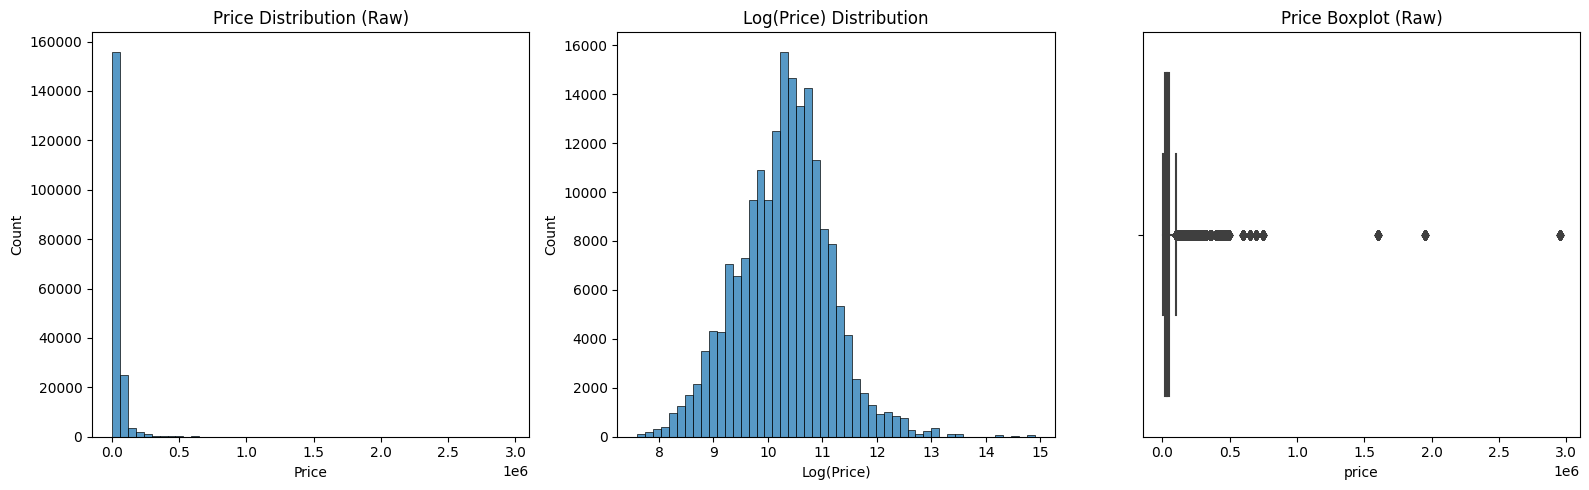

Price Stats:
count    188533.00
mean      43878.02
std       78819.52
min        2000.00
25%       17000.00
50%       30825.00
75%       49900.00
max     2954083.00
Name: price, dtype: float64


In [6]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.histplot(train['price'], bins=50, kde=False)
plt.title('Price Distribution (Raw)')
plt.xlabel('Price')

plt.subplot(1, 3, 2)
sns.histplot(np.log1p(train['price']), bins=50, kde=False)
plt.title('Log(Price) Distribution')
plt.xlabel('Log(Price)')

plt.subplot(1, 3, 3)
sns.boxplot(x=train['price'])
plt.title('Price Boxplot (Raw)')

plt.tight_layout()
plt.show()

print("Price Stats:")
print(train['price'].describe())

## Investigating the Impact of Missing Values on Price
Before deciding how to handle missing values, I ran a quick test to see whether missingness itself carried information about car price. The logic was simple: if cars with missing values in certain features consistently show higher or lower prices compared to those with complete data, then the missingness might not be random — and could actually be a useful signal for the model.

### Interpretation
* Across all three features (`horsepower`, `cylinders`, `engine_liters`), the **average price was significantly higher when values were missing**.
* For example, cars with missing horsepower values averaged around **\$64k**, compared to **\$39k** for those with recorded horsepower — a gap of nearly **\$25k**.
* Similar patterns held for cylinders and engine liters, though with slightly smaller differences.

This suggests that missing values are **not random**. They may correspond to higher-end vehicles where certain specs are either not disclosed in listings or structured differently (e.g., premium trims, hybrids, or electric cars that don’t fit traditional “cylinder” or “engine liter” categories).

### Implications for Modeling
* Simply filling in missing values with averages or medians could erase this signal.
* A better approach is to create **missingness indicator features** (e.g., `is_horsepower_missing = 1/0`) so the model can learn whether the absence of a value itself correlates with higher prices.
* This allows imputation to handle the numeric side, while the missing flag preserves potentially important information.

**In short:** missingness itself carries predictive power in this dataset, and rather than treating it as noise, it is to be engineered into features for the model.

In [7]:
# Compare average price when missing vs not missing
print("== Average Price When Feature is MISSING vs PRESENT ==")
for col in ['horsepower', 'cylinders', 'engine_liters']:
    missing_flag = train[col].isnull().astype(int)
    missing_mean = train.loc[missing_flag == 1, 'price'].mean()
    present_mean = train.loc[missing_flag == 0, 'price'].mean()
    print(f"{col}: Missing=${missing_mean:,.0f} | Present=${present_mean:,.0f} | Diff=${present_mean - missing_mean:,.0f}")

== Average Price When Feature is MISSING vs PRESENT ==
horsepower: Missing=$64,243 | Present=$39,516 | Diff=$-24,727
cylinders: Missing=$62,225 | Present=$42,271 | Diff=$-19,955
engine_liters: Missing=$57,507 | Present=$43,376 | Diff=$-14,131


## Exploring Model and Brand Cardinality
To better understand the structure of the dataset, I examined two categorical dimensions that are likely to strongly influence car prices: **base\_model** and **brand**. The goal was to check their cardinality (how many unique values exist) and explore which entries dominate by frequency or price.

### What was discovered
* **Base Models:**
  * There are **542 unique base models**, showing high cardinality.
  * The most common models in the dataset are mainstream, high-volume vehicles such as the **Range Rover (7.6k)**, **Ford F-150 (6.1k)**, and **Porsche 911 (5.3k)**.
  * This long tail distribution implies that many models have relatively few observations, which could make them harder for the model to learn from directly. Encoding strategies will need to account for this imbalance.

* **Brands:**
  * There are **57 unique brands**, which is more manageable.
  * The ranking by **median price** shows a clear hierarchy: ultra-luxury brands (**Bugatti, Lamborghini, McLaren**) dominate the top, with median prices far above the dataset average.
  * Interestingly, newer electric and luxury startups like **Rivian** and **Lucid** also appear in the top 10, reflecting their higher-end positioning in the market.

### Why This Matters for Modeling

* High cardinality in `base_model` suggests the need for techniques like **frequency encoding, target encoding, or grouping rare categories** so that the model can generalize without overfitting.
* For `brand`, the smaller set of categories means it can likely be encoded directly, but the clear stratification by price highlights its strong predictive power.
* Together, these features provide both **volume-driven signals** (e.g., popular mainstream models) and **luxury-driven signals** (e.g., brand prestige), which are crucial for accurate price prediction.

In [8]:
print("== Base Model Cardinality ==")
print(f"Unique base_model: {train['base_model'].nunique()}")
print(f"Top 10 base_model by count:")
print(train['base_model'].value_counts().head(10))

print("\n== Brand Cardinality ==")
print(f"Unique brand: {train['brand'].nunique()}")
print(f"Top 10 brand by median price:")
print(train.groupby('brand')['price'].median().sort_values(ascending=False).head(10))

== Base Model Cardinality ==
Unique base_model: 542
Top 10 base_model by count:
base_model
Range Rover    7647
F-150          6113
911            5303
AMG            5167
Corvette       4027
Mustang        3738
Camaro         3551
E-Class        3288
1500           3178
Wrangler       2903
Name: count, dtype: int64

== Brand Cardinality ==
Unique brand: 57
Top 10 brand by median price:
brand
Bugatti       220000.00
Lamborghini   102000.00
McLaren        87500.00
Rivian         78000.00
Rolls-Royce    77500.00
Ferrari        75500.00
Bentley        73600.00
Aston          67650.00
Lucid          56000.00
Maybach        54999.00
Name: price, dtype: float64


## Feature Engineering and Data Preparation

### 1. Creating Engineered Features
To make the dataset more useful for modeling, I created a set of engineered features. These included binary flags such as whether a car had an accident report, whether it carried a clean title, and whether its fuel type was missing. I also added missingness indicators for numeric features like horsepower, cylinders, and engine liters to preserve any signal in the null values.
Usage-based features such as car age, mileage per year, and log-transformed mileage were introduced to capture wear-and-tear patterns. A special flag was also added to identify whether a car belonged to the luxury brand category. These features gave the model richer signals beyond the raw dataset.

In [9]:
def create_engineered_features(train, test, luxury_brands=None):
    """
    Create engineered features from raw columns.
    Safe for train and test.
    Must be run BEFORE imputation.
    """
    if luxury_brands is None:
        luxury_brands = [
            'Bugatti', 'Lamborghini', 'McLaren', 'Rivian', 
            'Rolls-Royce', 'Ferrari', 'Bentley', 'Aston', 
            'Lucid', 'Maybach'
        ]
    
    # =============================
    # STEP 1: BINARY FLAGS
    # =============================
    # Accident
    train['has_accident_reported'] = (
        train['accident'] == 'At least 1 accident or damage reported'
    ).astype(int)
    test['has_accident_reported'] = (
        test['accident'] == 'At least 1 accident or damage reported'
    ).astype(int)
    
    # Clean title
    train['is_clean_title'] = (train['clean_title'] == 'Yes').astype(int)
    test['is_clean_title'] = (test['clean_title'] == 'Yes').astype(int)
    
    # Fuel unknown (based on missingness)
    train['is_fuel_unknown'] = train['fuel_type'].isnull().astype(int)
    test['is_fuel_unknown'] = test['fuel_type'].isnull().astype(int)
    
    # =============================
    # STEP 2: MISSINGNESS FLAGS (for numeric features)
    # =============================
    for col in ['horsepower', 'cylinders', 'engine_liters']:
        train[f'is_{col}_missing'] = train[col].isnull().astype(int)
        test[f'is_{col}_missing'] = test[col].isnull().astype(int)
    
    # =============================
    # STEP 3: AGE & USAGE FEATURES
    # =============================
    current_year = 2025
    
    train['car_age'] = current_year - train['model_year']
    test['car_age'] = current_year - test['model_year']
    
    train['mileage_per_year'] = train['milage'] / (train['car_age'] + 1)
    test['mileage_per_year'] = test['milage'] / (test['car_age'] + 1)
    
    train['log_mileage'] = np.log1p(train['milage'])
    test['log_mileage'] = np.log1p(test['milage'])
    
    # Create log_price in train (for target encoding later)
    if 'price' in train.columns:
        train['log_price'] = np.log1p(train['price'])
    
    # =============================
    # STEP 5: LUXURY BRAND FLAG
    # =============================
    train['is_luxury_brand'] = train['brand'].isin(luxury_brands).astype(int)
    test['is_luxury_brand'] = test['brand'].isin(luxury_brands).astype(int)
    
    return train, test

### 2. Dropping Sparse Columns
Some columns had more than 70% missing values, making them uninformative for modeling. These were dropped to reduce noise and simplify the dataset. In this case, three ultra-sparse columns—**aspiration, trim, and drivetrain**—were removed. This step ensured that the model wasn’t distracted by poorly populated fields.

In [10]:
def drop_sparse_columns(train, test, threshold=0.7):
    """
    Drop columns where more than threshold% of values are missing.
    Default: drop if >70% missing.
    """
    dropped_cols = []
    
    for col in train.columns:
        if train[col].isnull().mean() > threshold:
            dropped_cols.append(col)
    
    train = train.drop(columns=dropped_cols)
    test = test.drop(columns=dropped_cols)
    
    print(f"🗑️ Dropped {len(dropped_cols)} sparse columns: {dropped_cols}")
    return train, test

### 3. Imputing Missing Values
Next, I handled missing values systematically. For categorical features like `clean_title`, `accident`, and `fuel_type`, missing entries were filled with “Unknown.” For numeric fields, I used hierarchical strategies:

* **Horsepower** was imputed using brand and model medians.
* **Cylinders** were filled based on engine size bins, then brand, and finally overall median.
* **Engine liters** followed a similar layered median approach.
* **Number of speeds** was inferred from transmission type, with a fallback default.

A before-and-after report confirmed that all key columns had their missing values reduced to zero in both train and test sets.

In [11]:
def impute_missing_values_with_comparison(train, test):
    """
    Impute missing values with NO FutureWarnings.
    Returns detailed before/after stats.
    """
    impute_stats = {}
    
    # Track initial missing counts
    initial_missing = {
        'train': train.isnull().sum(),
        'test': test.isnull().sum()
    }
    
    # 1. Categoricals → "Unknown" + normalization
    for df in [train, test]:
        df.loc[:, 'clean_title'] = df['clean_title'].fillna('Unknown')
        df.loc[:, 'accident'] = df['accident'].fillna('Unknown')
        df.loc[:, 'fuel_type'] = (
            df['fuel_type']
            .fillna('Unknown')
            .replace({
                '–': 'Unknown',
                'not supported': 'Unknown',
                '': 'Unknown',   # empty strings
                None: 'Unknown'
            })
        )
    
    # 2. Horsepower
    hp_med_map = train.groupby(['brand', 'base_model'])['horsepower'].transform('median')
    train.loc[:, 'horsepower'] = train['horsepower'].fillna(hp_med_map)
    hp_med_brand = train.groupby('brand')['horsepower'].transform('median')
    train.loc[:, 'horsepower'] = train['horsepower'].fillna(hp_med_brand)
    train.loc[:, 'horsepower'] = train['horsepower'].fillna(train['horsepower'].median())
    
    test.loc[:, 'horsepower'] = test.groupby(['brand', 'base_model'])['horsepower'].transform('median')
    test.loc[:, 'horsepower'] = test.groupby('brand')['horsepower'].transform('median')
    test.loc[:, 'horsepower'] = test['horsepower'].fillna(train['horsepower'].median())  # ← Use TRAIN median!
    
    # 3. Cylinders
    train.loc[:, 'engine_liters_bin'] = pd.cut(train['engine_liters'], bins=10, labels=False)
    cyl_mode_map = train.groupby(['brand', 'engine_liters_bin'])['cylinders'].transform(
        lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )
    train.loc[:, 'cylinders'] = train['cylinders'].fillna(cyl_mode_map)
    train.loc[:, 'cylinders'] = train['cylinders'].fillna(train.groupby('brand')['cylinders'].transform('median'))
    train.loc[:, 'cylinders'] = train['cylinders'].fillna(train['cylinders'].median())
    
    test.loc[:, 'engine_liters_bin'] = pd.cut(test['engine_liters'], bins=10, labels=False)
    test.loc[:, 'cylinders'] = test.groupby(['brand', 'engine_liters_bin'])['cylinders'].transform(
        lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )
    test.loc[:, 'cylinders'] = test['cylinders'].fillna(test.groupby('brand')['cylinders'].transform('median'))
    test.loc[:, 'cylinders'] = test['cylinders'].fillna(train['cylinders'].median())
    
    # 4. Engine Liters
    train.loc[:, 'engine_liters'] = train.groupby(['brand', 'cylinders'])['engine_liters'].transform('median')
    train.loc[:, 'engine_liters'] = train['engine_liters'].fillna(train.groupby('brand')['engine_liters'].transform('median'))
    train.loc[:, 'engine_liters'] = train['engine_liters'].fillna(train['engine_liters'].median())
    
    test.loc[:, 'engine_liters'] = test.groupby(['brand', 'cylinders'])['engine_liters'].transform('median')
    test.loc[:, 'engine_liters'] = test['engine_liters'].fillna(test.groupby('brand')['engine_liters'].transform('median'))
    test.loc[:, 'engine_liters'] = test['engine_liters'].fillna(train['engine_liters'].median())
    
    # 5. Num Speeds
    train.loc[:, 'num_speeds'] = train.groupby('transmission_type')['num_speeds'].transform('median')
    train.loc[:, 'num_speeds'] = train['num_speeds'].fillna(8)
    
    test.loc[:, 'num_speeds'] = test.groupby('transmission_type')['num_speeds'].transform('median')
    test.loc[:, 'num_speeds'] = test['num_speeds'].fillna(8)
    
    # Final missing counts
    final_missing = {
        'train': train.isnull().sum(),
        'test': test.isnull().sum()
    }
    
    # Generate comparison report
    print("📊 === MISSING VALUE IMPUTATION REPORT ===")
    print(f"{'Column':<20} {'Train Before → After':<25} {'Test Before → After':<25}")
    print("-" * 75)
    
    key_cols = ['horsepower', 'cylinders', 'engine_liters', 'num_speeds', 'clean_title', 'accident', 'fuel_type']
    for col in key_cols:
        train_before = initial_missing['train'][col]
        train_after = final_missing['train'][col]
        test_before = initial_missing['test'][col]
        test_after = final_missing['test'][col]
        print(f"{col:<20} {train_before:>6} → {train_after:<6} {'':<5} {test_before:>6} → {test_after:<6}")
    
    # Return stats
    impute_stats = {
        'initial_missing': initial_missing,
        'final_missing': final_missing
    }
    
    return train, test, impute_stats

### 4. Target Encoding
To help the model capture relationships between categorical variables and price, I applied target encoding. Using the training data only (to prevent leakage), I encoded `base_model` and `brand` with the mean of the log-transformed price. This encoding replaced high-cardinality categories with smoother, numerical representations that carried useful pricing information.

In [12]:
train['log_price'] = np.log1p(train['price'])  # for target encoding & modeling

def create_target_encodings(train, test, cat_cols, target_col):
    """
    Create target encodings for categorical columns using TRAIN only.
    Applies to test using train's mappings — NO LEAKAGE.
    """
    for col in cat_cols:
        # Create mapping from train
        mapping = train.groupby(col)[target_col].mean()
        global_mean = train[target_col].mean()
        
        # Apply to train
        train[f'{col}_target_enc'] = train[col].map(mapping).fillna(global_mean)
        
        # Apply to test (using train's mapping!)
        test[f'{col}_target_enc'] = test[col].map(mapping).fillna(global_mean)
    
    return train, test

### 5. Final Feature Set
After all transformations, the dataset was considerably richer and cleaner. The training set ended up with **45 features**, while the test set had **43**, with most of the engineered features shared between them. At this point, the data was ready for modeling with a strong foundation of well-structured inputs.

In [13]:
# Define luxury brands
LUXURY_BRANDS = [
    'Bugatti', 'Lamborghini', 'McLaren', 'Rivian', 
    'Rolls-Royce', 'Ferrari', 'Bentley', 'Aston', 
    'Lucid', 'Maybach'
]

# Step 1: Feature Engineering
print("🔧 Step 1: Creating engineered features...")
train, test = create_engineered_features(train, test, luxury_brands=LUXURY_BRANDS)

# Step 2: Drop sparse columns (trim, body_style, etc.)
print("\n🗑️ Step 2: Dropping ultra-sparse columns...")
train, test = drop_sparse_columns(train, test, threshold=0.7)

# Step 3: Imputation with full report
print("\n🧪 Step 3: Imputing missing values...")
train, test, impute_stats = impute_missing_values_with_comparison(train, test)

# Step 4: Target Encoding
print("\n🎯 Step 4: Applying target encoding...")
train, test = create_target_encodings(
    train, 
    test, 
    cat_cols=['base_model', 'brand'], 
    target_col='log_price'
)

# Step 5: Show final feature count
print(f"\n✅ FINAL FEATURE COUNT:")
print(f"Train columns: {len(train.columns)}")
print(f"Test columns: {len(test.columns)}")
print(f"New features added: {len(train.columns) - len(train.columns.difference(test.columns))} (shared)")

🔧 Step 1: Creating engineered features...

🗑️ Step 2: Dropping ultra-sparse columns...
🗑️ Dropped 3 sparse columns: ['aspiration', 'trim', 'drivetrain']

🧪 Step 3: Imputing missing values...
📊 === MISSING VALUE IMPUTATION REPORT ===
Column               Train Before → After      Test Before → After      
---------------------------------------------------------------------------
horsepower            33259 → 0             22181 → 0     
cylinders             15186 → 0             10055 → 0     
engine_liters          6698 → 0              4380 → 0     
num_speeds            84286 → 0             56065 → 0     
clean_title           21419 → 0             14239 → 0     
accident               2452 → 0              1632 → 0     
fuel_type              5083 → 0              3383 → 0     

🎯 Step 4: Applying target encoding...

✅ FINAL FEATURE COUNT:
Train columns: 45
Test columns: 43
New features added: 43 (shared)


### 6. Leakage Checks
Before moving further, I added some guardrails to confirm that no information from the training set was leaking into the test set. Two key checks were performed:

1. **Price column check** – I confirmed that the test data had no `price` column, since the target should never appear in test. This ensured that the model wouldn’t accidentally “cheat” by seeing the answers.

2. **Target encoding validation** – To verify that encodings in the test set were derived strictly from the training set, I compared the target-encoded value for a sample brand across both datasets. The values matched perfectly, which confirmed there was no leakage in how encodings were applied.

These checks gave me confidence that the preprocessing pipeline was clean and safe for modeling.

In [17]:
# Check that test has no price column
assert 'price' not in test.columns, "Test data has price column — LEAKAGE!"

# Check that target encodings in test are based on train
sample_brand = train['brand'].iloc[0]
train_enc = train[train['brand'] == sample_brand]['brand_target_enc'].iloc[0]
test_enc = test[test['brand'] == sample_brand]['brand_target_enc'].iloc[0] if (test['brand'] == sample_brand).any() else None

if test_enc is not None:
    assert abs(train_enc - test_enc) < 1e-6, "Target encoding mismatch — possible leakage!"
    print(f"✅ Target encoding for brand '{sample_brand}' matches between train and test.")
else:
    print(f"⚠️ Brand '{sample_brand}' not found in test — but no leakage detected.")

✅ Target encoding for brand 'MINI' matches between train and test.


### 7. Post-Imputation Missing Value Review
After completing the full preprocessing pipeline (feature engineering, dropping sparse columns, imputations, and encodings), I ran a fresh check for missing values. The results showed that while many critical fields (e.g., `horsepower`, `cylinders`, `engine_liters`, `fuel_type`, `clean_title`) had been fully resolved, a few columns still contained missing data:

* **config** (over 100k missing)
* **extra\_descriptors** (806 missing)
* **body\_style** (43k missing)
* **transmission\_type** (19k missing)
* **engine\_liters\_bin** (6.6k missing — created during imputation)

Most of these fields, like `config` and `extra_descriptors`, appeared to add little meaningful information for prediction and were strong candidates for being dropped entirely. However, I paid closer attention to **`body_style`** and **`transmission_type`**, since both could reasonably influence used car pricing.

* *Body style* (e.g., sedan, SUV, coupe) captures market positioning and consumer demand, which often ties directly to resale price.
* *Transmission type* (automatic, manual, CVT, etc.) may impact desirability and price depending on the region and buyer preference.

Because of this, the plan was to drop columns with high missingness and low predictive value, while carefully considering whether to impute or otherwise handle `body_style` and `transmission_type` rather than discarding them outright.

This step ensured that the dataset was both clean and still preserved features most relevant for price modeling.

In [18]:
train.isnull().sum()

id                               0
brand                            0
model                            0
model_year                       0
milage                           0
fuel_type                        0
engine                           0
transmission                     0
ext_col                          0
int_col                          0
accident                         0
clean_title                      0
horsepower                       0
engine_liters                    0
cylinders                        0
config                      104907
extra_descriptors              806
base_model                       0
body_style                   43144
base_color                       0
paint_finish                     0
two_tone                         0
raw_ext_col                      0
base_int_color                   0
material                         0
raw_int_col                      0
transmission_type            19782
num_speeds                       0
has_auto_shift      

### 8. Exploring Body Style and Transmission Type

Before deciding how to handle missing values in `body_style` and `transmission_type`, I explored their distributions to understand how representative the available data was.

**Body Style**
The dataset was heavily concentrated around a few categories:

* **SUVs** (45k) and **Sedans** (37k) dominated the sample, together accounting for nearly half of all entries.
* **Coupes** (32k) and **Trucks** (18k) also formed significant portions.
* Niche categories like **Convertibles** (4.8k), **Vans** (3.4k), **Hatchbacks** (2.4k), and **Wagons** (1.2k) were far less common.

This skew suggests that while most vehicles fall into mainstream body types, rarer categories could still provide useful signals for pricing.

In [19]:
train["body_style"].value_counts()

body_style
SUV            45415
Sedan          37718
Coupe          32272
Truck          18013
Convertible     4841
Van             3442
Hatchback       2474
Wagon           1214
Name: count, dtype: int64

**Transmission Type**
Here the imbalance was even more striking:

* **Automatic** transmissions dominated with \~150k vehicles, dwarfing the other categories.
* **Manual** (16k) and **CVT** (2.8k) had moderate presence.
* **DCT** (18) and **Single-Speed** (16) were essentially negligible in scale.

In [20]:
train["transmission_type"].value_counts()

transmission_type
Automatic       149488
Manual           16395
CVT               2834
DCT                 18
Single-Speed        16
Name: count, dtype: int64

The takeaway was that both `body_style` and `transmission_type` carry meaningful information for price prediction, though they are heavily imbalanced. Missing values here couldn’t just be dropped blindly — they needed thoughtful handling to retain their predictive contribution without introducing noise.

### 9. Investigating Fill Strategies for Body Style and Transmission Type

After identifying `body_style` and `transmission_type` as potentially important predictors, I inspected how reliably these missing values could be imputed using brand, base model, and model year as reference keys.

The idea was simple: if a particular (brand, model, year) combination always appeared with the same body style or transmission type, then missing values for that group could be filled with high confidence.

The inspection confirmed that:

* **Body Style**
  * *Training set*: 43,144 entries were missing (22.9%). Out of these, **7,908 (18.3%)** could be imputed, leaving **35,236 (81.7%)** still missing.
  * *Test set*: 28,863 entries were missing (23.0%). Out of these, **5,318 (18.4%)** could be filled, with **23,545 (81.6%)** remaining.

* **Transmission Type**
  * *Training set*: 19,782 entries were missing (10.5%). Here, **8,034 (40.6%)** could be imputed, leaving **11,748 (59.4%)** unresolved.
  * *Test set*: 13,196 entries were missing (10.5%). Out of these, **5,266 (39.9%)** could be filled, while **7,930 (60.1%)** remained missing.

This means imputation helped partially recover the missing data — particularly for `transmission_type`, where about 40% could be reconstructed. However, the majority of missing values (especially for `body_style`) still lacked sufficient reference points, leaving a decision between dropping those records or creating an explicit “unknown” category for the model to learn from.

In [21]:
# Refactored Inspection & Mapping Function
def get_imputation_mapping(dataframe, target_column):
    """
    Efficiently identifies groups (brand, model, year) with a single consistent
    non-null value and returns a mapping for imputation.

    Args:
        dataframe (pd.DataFrame): The DataFrame to inspect.
        target_column (str): The column with missing values to inspect.

    Returns:
        pd.Series: A Series mapping (brand, model, year) to the value to impute.
    """
    # Check if the target column exists in the dataframe
    if target_column not in dataframe.columns:
        print(f"Warning: '{target_column}' not found in the DataFrame. Skipping inspection.")
        return None

    # Group by the key columns and get a count of unique non-null values
    grouped = dataframe.groupby(['brand', 'base_model', 'model_year'])[target_column].nunique(dropna=True)
    
    # Filter for groups that have only one unique value
    confident_groups = grouped[grouped == 1].index
    
    # Create the mapping by selecting the first non-null value from these groups
    mapping = dataframe.set_index(['brand', 'base_model', 'model_year']).loc[confident_groups][target_column].dropna()
    
    # Drop duplicates to ensure a unique mapping for each key
    mapping = mapping[~mapping.index.duplicated(keep='first')]
    
    return mapping

def inspect_with_mapping(dataframe, target_column, mapping, dataset_name):
    """
    Analyzes a DataFrame's missing values using a pre-computed mapping.
    
    Args:
        dataframe (pd.DataFrame): The DataFrame to inspect.
        target_column (str): The column with missing values to inspect.
        mapping (pd.Series): The imputation mapping to use.
        dataset_name (str): The name of the dataset (e.g., "TRAINING", "TEST").
    """
    print(f"=== Analyzing the {dataset_name} set for '{target_column}' ===")

    if target_column not in dataframe.columns:
        print(f"Column '{target_column}' does not exist in the {dataset_name} set. Skipping analysis.")
        print("\n" + "="*50 + "\n")
        return

    # Check for missing values
    missing_count = dataframe[target_column].isnull().sum()
    total_rows = len(dataframe)
    missing_percent = (missing_count / total_rows) * 100
    print(f"Total rows with missing '{target_column}': {missing_count} ({missing_percent:.2f}%)")

    # Use the mapping to identify how many of the missing values can be filled
    dataframe_with_index = dataframe.set_index(['brand', 'base_model', 'model_year'])
    potential_fills = dataframe_with_index.loc[dataframe_with_index.index.isin(mapping.index)]
    
    fillable_missing_count = potential_fills[target_column].isnull().sum()

    print(f"Number of missing values that can be filled by the mapping: {fillable_missing_count}")
    print(f"Number of remaining missing values: {missing_count - fillable_missing_count}")
    print("\n" + "="*50 + "\n")


# --- 3. Run the Inspection for Both Columns and Datasets ---
if __name__ == '__main__':
    # First, get the imputation mappings from the TRAINING data only.
    # This is critical to prevent data leakage from the test set.
    body_style_mapping = get_imputation_mapping(train, 'body_style')
    transmission_mapping = get_imputation_mapping(train, 'transmission_type')

    # Now, use these mappings to analyze the train and test sets.
    inspect_with_mapping(train, 'body_style', body_style_mapping, 'TRAINING')
    inspect_with_mapping(train, 'transmission_type', transmission_mapping, 'TRAINING')

    # Note: It appears your test set has one fewer column than your training set.
    # This refactored code gracefully handles the case where a target column
    # is missing from one of the dataframes.

    inspect_with_mapping(test, 'body_style', body_style_mapping, 'TEST')
    inspect_with_mapping(test, 'transmission_type', transmission_mapping, 'TEST')

=== Analyzing the TRAINING set for 'body_style' ===
Total rows with missing 'body_style': 43144 (22.88%)
Number of missing values that can be filled by the mapping: 7908
Number of remaining missing values: 35236


=== Analyzing the TRAINING set for 'transmission_type' ===
Total rows with missing 'transmission_type': 19782 (10.49%)
Number of missing values that can be filled by the mapping: 8034
Number of remaining missing values: 11748


=== Analyzing the TEST set for 'body_style' ===
Total rows with missing 'body_style': 28863 (22.96%)
Number of missing values that can be filled by the mapping: 5318
Number of remaining missing values: 23545


=== Analyzing the TEST set for 'transmission_type' ===
Total rows with missing 'transmission_type': 13196 (10.50%)
Number of missing values that can be filled by the mapping: 5266
Number of remaining missing values: 7930




### 10. Imputation Strategy for Body Style and Transmission Type
To address missing values in `body_style` and `transmission_type`, I implemented a multi-step imputation pipeline that combined targeted mapping, brand-level rules, and sensible defaults.

**Step 1. Apply Pre-computed Mapping**
A helper function `apply_imputation_mapping()` was created to leverage mappings derived from `(brand, base_model, model_year)` combinations. This function:
* Builds a temporary key for each row.
* Uses the mapping dictionary to replace missing values wherever a match exists.
* Removes the temporary key after completion.

Outcome:
* **8,034** missing `transmission_type` values were filled in the training set.
* **5,266** missing `transmission_type` values were filled in the test set.
* This stage alone resolved \~40% of missingness in transmission type.

**Step 2. Missingness Flags**
Before imputation, binary flags were created to capture whether `body_style` or `transmission_type` was missing. These features (`is_body_style_missing`, `is_transmission_type_missing`) were preserved to allow the model to learn from the fact that some entries had incomplete data.

**Step 3. Hierarchical Imputation for Transmission Type**
For unresolved missing values after mapping:

1. Filled with the **most common transmission type within each brand**.
2. Remaining gaps defaulted to `'Automatic'`, since it dominated the dataset (149k+ entries).

This ensured all transmission records were consistently filled.

**Step 4. Hierarchical Imputation for Body Style**
For `body_style`, a similar hierarchical approach was applied:

1. Filled missing values using the **most frequent body style within each (brand, base\_model)** combination.
2. If still missing, filled using the **most common style for that brand**.
3. As a final fallback, missing entries defaulted to `'Sedan'`, reflecting its strong representation in the data (37k entries).

**Step 5. Target Encoding**
After imputation, both `body_style` and `transmission_type` were target-encoded against the log-transformed price. This step converted categorical values into numeric features that captured their statistical relationship with the target variable, enhancing predictive power without introducing leakage.

In [22]:
def apply_imputation_mapping(train, test, target_column, mapping):
    """
    Apply a pre-computed mapping to fill missing values in train and test.
    Uses (brand, base_model, model_year) as key (to match mapping).
    """
    if mapping is None:
        print(f"⚠️ No mapping for {target_column} — skipping.")
        return train, test
    
    # Create a temporary key (consistent with mapping)
    for df in [train, test]:
        df['_key'] = list(zip(df['brand'], df['base_model'], df['model_year']))
    
    # Convert mapping to dict for fast lookup
    mapping_dict = mapping.to_dict()
    
    # Fill missing values in train
    mask_train = train[target_column].isnull() & train['_key'].isin(mapping_dict.keys())
    train.loc[mask_train, target_column] = train.loc[mask_train, '_key'].map(mapping_dict)
    filled_train = mask_train.sum()
    
    # Fill missing values in test
    mask_test = test[target_column].isnull() & test['_key'].isin(mapping_dict.keys())
    test.loc[mask_test, target_column] = test.loc[mask_test, '_key'].map(mapping_dict)
    filled_test = mask_test.sum()
    
    # Clean up
    for df in [train, test]:
        df.drop(columns=['_key'], inplace=True)
    
    print(f"✅ Filled {filled_train} missing '{target_column}' in train using mapping.")
    print(f"✅ Filled {filled_test} missing '{target_column}' in test using mapping.")
    
    return train, test

In [23]:
# Step 1: Create missingness flags (BEFORE imputation)
train['is_transmission_type_missing'] = train['transmission_type'].isnull().astype(int)
test['is_transmission_type_missing'] = test['transmission_type'].isnull().astype(int)

train['is_body_style_missing'] = train['body_style'].isnull().astype(int)
test['is_body_style_missing'] = test['body_style'].isnull().astype(int)

# Step 2: Fill transmission_type with your mapping
train, test = apply_imputation_mapping(train, test, 'transmission_type', transmission_mapping)

# Step 3: Fill remaining transmission_type with mode by brand
brand_mode_trans = train.groupby('brand')['transmission_type'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Automatic')
train['transmission_type'] = train['transmission_type'].fillna(train['brand'].map(brand_mode_trans))
test['transmission_type'] = test['transmission_type'].fillna(test['brand'].map(brand_mode_trans))
train['transmission_type'].fillna('Automatic', inplace=True)
test['transmission_type'].fillna('Automatic', inplace=True)

# Step 4: Fill body_style with mode by brand + base_model
train['_brand_base'] = train['brand'] + '|' + train['base_model']
test['_brand_base'] = test['brand'] + '|' + test['base_model']

brand_base_mode_body = train.groupby('_brand_base')['body_style'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
train['body_style'] = train['body_style'].fillna(train['_brand_base'].map(brand_base_mode_body))
test['body_style'] = test['body_style'].fillna(test['_brand_base'].map(brand_base_mode_body))

brand_mode_body = train.groupby('brand')['body_style'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Sedan')
train['body_style'] = train['body_style'].fillna(train['brand'].map(brand_mode_body))
test['body_style'] = test['body_style'].fillna(test['brand'].map(brand_mode_body))

train['body_style'].fillna('Sedan', inplace=True)
test['body_style'].fillna('Sedan', inplace=True)

# Clean up
for df in [train, test]:
    df.drop(columns=['_brand_base'], inplace=True)

# Step 5: Target encode
train, test = create_target_encodings(
    train, 
    test, 
    cat_cols=['body_style', 'transmission_type'], 
    target_col='log_price'
)

✅ Filled 8034 missing 'transmission_type' in train using mapping.
✅ Filled 5266 missing 'transmission_type' in test using mapping.


**Final Results**
Post-imputation checks confirmed:

* **0 missing values** for `body_style` in both train and test.
* **0 missing values** for `transmission_type` in both train and test.

This workflow ensured that all rows were preserved, the categorical variables were fully usable for modeling, and the imputation process maintained consistency between training and test sets.

In [24]:
print("=== AFTER IMPUTATION ===")
print(f"Train body_style missing: {train['body_style'].isnull().sum()}")
print(f"Train transmission_type missing: {train['transmission_type'].isnull().sum()}")
print(f"Test body_style missing: {test['body_style'].isnull().sum()}")
print(f"Test transmission_type missing: {test['transmission_type'].isnull().sum()}")

=== AFTER IMPUTATION ===
Train body_style missing: 0
Train transmission_type missing: 0
Test body_style missing: 0
Test transmission_type missing: 0


### Identifying Luxury Brands
This block defined luxury brands as those with a **median price above \$60,000**. By grouping the training set by `brand` and calculating median prices, a list of brands crossing the threshold was created. A new binary flag `is_luxury_brand` was then added to both the training and test sets to capture whether a vehicle belongs to this luxury segment.

**Result:**
A total of **8 luxury brands** were identified:
`['Aston', 'Bentley', 'Bugatti', 'Ferrari', 'Lamborghini', 'McLaren', 'Rivian', 'Rolls-Royce']`.

In [27]:
# Define luxury brands as those with median price > $60,000
luxury_threshold = 60000
brand_median_price = train.groupby('brand')['price'].median()
luxury_brands = brand_median_price[brand_median_price > luxury_threshold].index.tolist()

train['is_luxury_brand'] = train['brand'].isin(luxury_brands).astype(int)
test['is_luxury_brand'] = test['brand'].isin(luxury_brands).astype(int)

print(f"✅ Created is_luxury_brand — {len(luxury_brands)} luxury brands identified:")
print(luxury_brands)

✅ Created is_luxury_brand — 8 luxury brands identified:
['Aston', 'Bentley', 'Bugatti', 'Ferrari', 'Lamborghini', 'McLaren', 'Rivian', 'Rolls-Royce']


### Numeric Feature Analysis
Here I performed a deeper diagnostic on numeric features in three ways:
1. **Correlation with Price** – Each numeric feature was ranked by how strongly it correlated with the target variable.
   * Strongest negative correlations were found for `log_mileage (-0.31)` and `milage (-0.28)`, confirming that higher mileage lowers price.
   * Positive correlations included `horsepower (0.25)` and `model_year (0.23)`, reflecting that newer, more powerful cars tend to be more expensive.

2. **Skewness** – Assessed distributional skew for numeric features.
   * Highly skewed variables included `has_auto_shift (9.86)` and `num_speeds (-2.93)`, suggesting transformation or careful treatment may be required.
   * Most continuous features such as `horsepower (0.78)` and `engine_liters (0.51)` showed mild skewness.

3. **Outliers (IQR Method)** – Outlier counts and proportions were flagged.
   * `num_speeds` had the highest outlier rate, with **16,413 cases (8.7%)** outside the IQR range.
   * Mileage-related variables (`log_mileage: 7,521 outliers, 4.0%`) and temporal features (`model_year` and `car_age`: \~2.7% each) also exhibited notable outliers.

In [28]:
# Identify numeric columns (exclude target encodings and binary flags for now)
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
exclude_cols = [
    'id', 'log_price', 'price', 
    'base_model_target_enc', 'brand_target_enc', 
    'body_style_target_enc', 'transmission_type_target_enc',
    'has_accident_reported', 'is_clean_title', 'is_fuel_unknown',
    'is_horsepower_missing', 'is_cylinders_missing', 'is_engine_liters_missing',
    'is_luxury_brand', 'is_transmission_type_missing', 'is_body_style_missing'
]

numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

# Calculate correlation with price
corr_with_price = train[numeric_cols + ['price']].corr()['price'].drop('price').sort_values(key=abs, ascending=False)

print("📊 === NUMERIC FEATURES — CORRELATION WITH PRICE ===")
print(corr_with_price.to_string())

# Calculate skewness
from scipy.stats import skew

skewness = train[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(key=abs, ascending=False)

print("\n📉 === NUMERIC FEATURES — SKEWNESS ===")
print(skewness.to_string())

# Identify outliers (using IQR)
outlier_info = {}
for col in numeric_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((train[col] < lower_bound) | (train[col] > upper_bound)).sum()
    outlier_pct = outliers / len(train) * 100
    outlier_info[col] = {'outliers': outliers, 'pct': outlier_pct}

print("\n🚨 === NUMERIC FEATURES — OUTLIERS (IQR METHOD) ===")
for col, info in sorted(outlier_info.items(), key=lambda x: x[1]['pct'], reverse=True):
    if info['pct'] > 1:
        print(f"{col:<20} : {info['outliers']:>6} outliers ({info['pct']:.1f}%)")

📊 === NUMERIC FEATURES — CORRELATION WITH PRICE ===
log_mileage         -0.31
milage              -0.28
horsepower           0.25
car_age             -0.23
model_year           0.23
mileage_per_year    -0.19
cylinders            0.13
has_auto_shift       0.10
engine_liters_bin    0.10
engine_liters        0.09
num_speeds           0.04

📉 === NUMERIC FEATURES — SKEWNESS ===
has_auto_shift       9.86
num_speeds          -2.93
mileage_per_year     1.67
log_mileage         -1.35
car_age              1.04
model_year          -1.04
milage               0.90
horsepower           0.78
engine_liters        0.51
engine_liters_bin    0.42
cylinders            0.25

🚨 === NUMERIC FEATURES — OUTLIERS (IQR METHOD) ===
num_speeds           :  16413 outliers (8.7%)
log_mileage          :   7521 outliers (4.0%)
model_year           :   5132 outliers (2.7%)
car_age              :   5132 outliers (2.7%)
mileage_per_year     :   3316 outliers (1.8%)
horsepower           :   2832 outliers (1.5%)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


### Categorical Feature Predictive Power
Here, the predictive strength of categorical features was assessed by computing the **variance of their target encodings** (mean price per category). A higher variance indicates stronger differentiation in price across categories, hence higher predictive power.

**Results (Top Predictors):**
* `material` stood out as the strongest categorical predictor with a variance of **\$9.87B across 2 categories**, suggesting a major price split depending on material type.
* `brand (\$1.30B variance, 57 categories)` and `transmission_type (\$1.20B variance, 5 categories)` also ranked highly, confirming their strong role in pricing.
* `base_model` showed predictive power as well (\$1.16B variance, 542 categories), though its large number of categories increases complexity.
* Features like `paint_finish (\$648M)` and `base_color (\$245M)` provided moderate predictive signals, while `fuel_type (\$122M)` and `body_style (\$133M)` were weaker by comparison.

In [29]:
# Categorical columns to analyze
cat_cols = ['brand', 'base_model', 'fuel_type', 'transmission_type', 'body_style', 'base_color', 'paint_finish', 'material', 'base_int_color']

print("🎯 === CATEGORICAL FEATURES — PREDICTIVE POWER (VARIANCE OF TARGET ENCODING) ===")

cat_predictive_power = {}

for col in cat_cols:
    # Compute target encoding (mean price per category)
    target_enc = train.groupby(col)['price'].mean()
    # Compute variance of target encoding → high variance = high predictive power
    variance = target_enc.var()
    n_categories = train[col].nunique()
    cat_predictive_power[col] = {
        'variance': variance,
        'n_categories': n_categories
    }

# Sort by variance (descending)
sorted_cats = sorted(cat_predictive_power.items(), key=lambda x: x[1]['variance'], reverse=True)

for col, info in sorted_cats:
    print(f"{col:<20} : Variance=${info['variance']:>12,.0f} | Categories={info['n_categories']}")

🎯 === CATEGORICAL FEATURES — PREDICTIVE POWER (VARIANCE OF TARGET ENCODING) ===
material             : Variance=$9,869,372,095 | Categories=2
brand                : Variance=$1,298,212,649 | Categories=57
transmission_type    : Variance=$1,202,098,793 | Categories=5
base_model           : Variance=$1,158,580,683 | Categories=542
paint_finish         : Variance=$ 647,939,532 | Categories=6
base_color           : Variance=$ 244,808,306 | Categories=14
base_int_color       : Variance=$ 160,210,716 | Categories=11
body_style           : Variance=$ 132,870,027 | Categories=8
fuel_type            : Variance=$ 122,176,916 | Categories=6


### **Follow-up Decision:**

Although `material` ranked highest in variance, the feature itself lacked meaningful variability. Nearly all entries were labeled as `unknown (188,356)` versus just `leather (177)`, making the feature heavily imbalanced and uninformative. For this reason, `material` was dropped from the dataset despite its apparent variance, as the predictive signal was artificial and driven by the dominance of the `unknown` category rather than genuine information.

In [30]:
train["material"].value_counts()

material
Unknown    188356
Leather       177
Name: count, dtype: int64

In [33]:
# Keep ids safe before dropping
train_ids = train['id'].copy()
test_ids = test['id'].copy()

## Pre-Model Feature Engineering and Refinement
Before moving to model training, I focused on systematically preparing the dataset to ensure cleaner inputs and more stable learning. The steps taken here were shaped directly by earlier investigations into outliers, skewness, and categorical feature behavior.

### 1. Removing Irrelevant and Redundant Features
Several columns were excluded because they either carried no predictive signal (e.g., identifiers, descriptive text, raw color fields) or risked introducing noise and redundancy. Consolidating these removals into a single pipeline step ensured consistency between train and test sets.

In [34]:
to_drop = [
    'id',
    'model',
    'engine',
    'transmission',
    'ext_col',
    'int_col',
    'accident',
    'clean_title',
    'config',
    'extra_descriptors',
    'raw_ext_col',
    'raw_int_col',
    'special_notes',
    'engine_liters_bin',
    'base_model'
]

### 2. Handling Skewness with Log Transforms
From the skewness analysis, I identified that both **car age** and **mileage per year** exhibited long-tailed distributions. Applying log transforms reduced their skew, making them more Gaussian-like and better suited for models sensitive to feature distribution. The raw versions of these features were then dropped to avoid duplication.

In [35]:
# Log transforms for skewed features
train['log_mileage_per_year'] = np.log1p(train['mileage_per_year'])
test['log_mileage_per_year'] = np.log1p(test['mileage_per_year'])

train['log_car_age'] = np.log1p(train['car_age'])
test['log_car_age'] = np.log1p(test['car_age'])

# Combine all columns to drop
final_drop = to_drop + ['model_year', 'mileage_per_year', 'car_age']

# Drop them in one go
train_df = train.drop(columns=final_drop, errors='ignore')
test_df = test.drop(columns=final_drop, errors='ignore')

### 3. Capping Extreme Outliers
Our earlier outlier checks revealed heavy right tails in variables like horsepower and log-transformed mileage. Instead of discarding data, I applied percentile-based capping — clipping horsepower at the 99th percentile and log mileage between the 1st and 99th. This approach retained most of the data while reducing the influence of extreme points.

In [36]:
# Cap horsepower at 99th percentile
hp_99 = train_df['horsepower'].quantile(0.99)
train_df['horsepower'] = train_df['horsepower'].clip(upper=hp_99)
test_df['horsepower'] = test_df['horsepower'].clip(upper=hp_99)

# Cap log_mileage at 1st and 99th percentiles
lm_01 = train_df['log_mileage'].quantile(0.01)
lm_99 = train_df['log_mileage'].quantile(0.99)
train_df['log_mileage'] = train_df['log_mileage'].clip(lower=lm_01, upper=lm_99)
test_df['log_mileage'] = test_df['log_mileage'].clip(lower=lm_01, upper=lm_99)

### 4. Encoding Categorical Variables
Categorical features required tailored treatment:
* **Dropped Columns with No Variability:** e.g., *material* showed no variation across rows and was excluded.
* **Target Encoding for Base Color:** Instead of one-hot encoding all 14 categories, I used mean target encoding, replacing colors with the average log-price of cars in that color. This preserved signal strength without over-expanding dimensions.
* **One-Hot Encoding for Key Features:** Variables like *transmission type, paint finish, body style, fuel type,* and *base interior color* were one-hot encoded, adding 36 new binary columns.

### 5. Final Dataset Shape
After all refinements, the training set contained **62 columns** (including price-related targets) and the test set contained **60 columns**. This finalized dataset provided a balanced mix of numeric and encoded categorical features, optimized for downstream modeling

In [37]:
# 1. DROP material — no variability
train_df = train_df.drop(columns=['material'], errors='ignore')
test_df = test_df.drop(columns=['material'], errors='ignore')

# 2. DROP raw brand — use brand_target_enc
train_df = train_df.drop(columns=['brand'], errors='ignore')
test_df = test_df.drop(columns=['brand'], errors='ignore')

# 3. TARGET ENCODE base_color (14 categories)
# Compute mapping from train only
base_color_target_map = train_df.groupby('base_color')['log_price'].mean()
global_price_mean = train_df['log_price'].mean()

train_df['base_color_target_enc'] = train_df['base_color'].map(base_color_target_map).fillna(global_price_mean)
test_df['base_color_target_enc'] = test_df['base_color'].map(base_color_target_map).fillna(global_price_mean)

# Drop raw base_color
train_df = train_df.drop(columns=['base_color'], errors='ignore')
test_df = test_df.drop(columns=['base_color'], errors='ignore')

# 4. ONE-HOT ENCODE: transmission_type, paint_finish, body_style, fuel_type
# Columns to one-hot encode
ohe_cols = ['transmission_type', 'paint_finish', 'body_style', 'fuel_type', 'base_int_color']

# Initialize encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on train
ohe.fit(train_df[ohe_cols].astype(str))

# Transform train
ohe_train = ohe.transform(train_df[ohe_cols].astype(str))
ohe_train_df = pd.DataFrame(ohe_train, columns=ohe.get_feature_names_out(ohe_cols), index=train_df.index)

# Transform test
ohe_test = ohe.transform(test_df[ohe_cols].astype(str))
ohe_test_df = pd.DataFrame(ohe_test, columns=ohe.get_feature_names_out(ohe_cols), index=test_df.index)

# Concatenate
train_df = pd.concat([train_df.drop(columns=ohe_cols), ohe_train_df], axis=1)
test_df = pd.concat([test_df.drop(columns=ohe_cols), ohe_test_df], axis=1)

print(f"✅ One-Hot Encoding complete. Added {ohe_train_df.shape[1]} columns.")
print(f"   Train shape: {train_df.shape}")
print(f"   Test shape: {test_df.shape}")

✅ One-Hot Encoding complete. Added 36 columns.
   Train shape: (188533, 62)
   Test shape: (125690, 60)


## Building the Models
### First Model: Ridge Regression
For my baseline model, I started with **Ridge Regression**. This was a good first step because Ridge is:
* A linear model that’s easy to interpret
* Regularized (L2 penalty), which makes it less sensitive to multicollinearity
* A strong benchmark before moving to more flexible models

#### Setup
* Target: `log_price`(raw `price` was dropped)
* Features: 60 engineered predictors
* Scaling: Applied **StandardScaler** inside each fold (Ridge is scale-sensitive)

#### Cross-Validation Strategy
I didn’t use plain KFold. Instead, I went with **StratifiedKFold**, but adapted it for regression:
* Created bins of *log\_price* (10 quantile-based bins)
* Ensured each fold had a balanced mix of cheap ↔ expensive cars
* This was smart because it gave me more stable and representative validation scores, reducing variance across folds and improving generalization to the unseen test set.

#### Results
* **Fold RMSEs (raw price scale):**
  * Fold 1: 67,084
  * Fold 2: 71,486
  * Fold 3: 76,148
  * Fold 4: 77,704
  * Fold 5: 77,291
* **Final CV RMSE:** 74,055
* **Mean Fold RMSE:** 73,943 ± 4,082

#### Notes
* Out-of-fold (OOF) predictions were saved for stacking (`ridge_oof.npy`).
* This gave me a solid baseline: Ridge isn’t complex, but it proved my features were carrying real signal.

In [60]:
# Drop 'price' for training (keep 'log_price' as target)
train_modeling = train_df.drop(columns=['price'], errors='ignore')
test_modeling = test_df  # test has no price

# Final feature list (all 60 features except 'price' and 'log_price')
feature_cols = [col for col in train_modeling.columns if col not in ['log_price']]
X = train_modeling[feature_cols]
y = train_modeling['log_price']  # ← TARGET: log_price
X_test = test_modeling[feature_cols]

# 2. CREATE PRICE BINS FOR STRATIFIED K-FOLD
train_modeling['price_bin'] = pd.qcut(train_modeling['log_price'], q=10, labels=False)

# 3. STRATIFIED K-FOLD CV (5 FOLDS)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds_log = np.zeros(len(X))
test_preds_log = np.zeros(len(X_test))
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, train_modeling['price_bin'])):
    print(f"=== FOLD {fold+1} ===")
    
    # Split data
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_val_fold = y.iloc[val_idx]
    
    # Scale features (Ridge needs scaling)
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Ridge
    model = Ridge(alpha=1.0, random_state=42)
    model.fit(X_train_fold_scaled, y_train_fold)
    
    # Predict on validation (log scale)
    val_pred_log = model.predict(X_val_fold_scaled)
    oof_preds_log[val_idx] = val_pred_log
    
    # Convert to raw price for scoring
    val_pred_price = np.expm1(val_pred_log)
    y_val_price = np.expm1(y_val_fold)
    
    # Score on RAW price (RMSE)
    fold_rmse = np.sqrt(mean_squared_error(y_val_price, val_pred_price))
    fold_scores.append(fold_rmse)
    print(f"  Fold {fold+1} RMSE (raw price): {fold_rmse:.2f}")
    
    # Predict on test (log scale) → average later
    test_pred_log = model.predict(X_test_scaled)
    test_preds_log += test_pred_log / 5

# 4. FINAL CV SCORE
oof_preds_price = np.expm1(oof_preds_log)  # ← RAW PRICE OOF
y_train_price = np.expm1(y)
cv_rmse = np.sqrt(mean_squared_error(y_train_price, oof_preds_price))
print(f"\n✅ FINAL CV RMSE (raw price): {cv_rmse:.2f}")
print(f"✅ FOLD SCORES: {fold_scores}")
print(f"✅ MEAN FOLD RMSE: {np.mean(fold_scores):.2f} ± {np.std(fold_scores):.2f}")

# 5. SAVE OOF PREDICTIONS FOR STACKING (RAW PRICE)
np.save('/kaggle/working/ridge_oof.npy', oof_preds_price)  # ← ADDED THIS LINE
print(f"✅ Saved ridge_oof.npy (shape: {oof_preds_price.shape}) for stacking.")

=== FOLD 1 ===
  Fold 1 RMSE (raw price): 67084.05
=== FOLD 2 ===
  Fold 2 RMSE (raw price): 71486.05
=== FOLD 3 ===
  Fold 3 RMSE (raw price): 76147.90
=== FOLD 4 ===
  Fold 4 RMSE (raw price): 77704.37
=== FOLD 5 ===
  Fold 5 RMSE (raw price): 77291.42

✅ FINAL CV RMSE (raw price): 74055.29
✅ FOLD SCORES: [67084.04908556341, 71486.04717802184, 76147.904179928, 77704.37256796678, 77291.41963145764]
✅ MEAN FOLD RMSE: 73942.76 ± 4081.75
✅ Saved ridge_oof.npy (shape: (188533,)) for stacking.


### Sanity Check: Beating the Mean Price Baseline
Before moving on, I wanted to confirm whether Ridge was actually learning anything useful, or if it was no better than just predicting the **average car price for everyone**.

* The **mean price baseline RMSE** came out to **\$78,819**.
* In comparison, Ridge achieved a **CV RMSE of \~\$74,055**, comfortably lower than the baseline.

This gap shows that Ridge was already capturing meaningful relationships between features and price. Even though the improvement isn’t massive, it’s a good sign that the pipeline is on the right track.

In [40]:
# Check if Ridge is better than predicting mean price
mean_price = y_train_price.mean()
baseline_preds = np.full(len(y_train_price), mean_price)
baseline_rmse = np.sqrt(mean_squared_error(y_train_price, baseline_preds))
print(f"🎯 Mean Price Baseline RMSE: ${baseline_rmse:,.0f}")

🎯 Mean Price Baseline RMSE: $78,819


In [41]:
'''
# 5. FINAL TEST PREDICTIONS (replace price in sub with predictions)
test_preds_price = np.expm1(test_preds_log)

# Drop old price column if it exists
sub = sub.drop(columns=['price'], errors='ignore')

# Insert predictions
sub['price'] = test_preds_price

# Save submission
sub.to_csv('submission_ridge_baseline.csv', index=False)

print(f"\n✅ Submission saved: submission_ridge_baseline.csv")
print(f"📊 Submission shape: {sub.shape}")
print(f"📈 Sample predictions:\n{sub.head().to_string(index=False)}")'''

'\n# 5. FINAL TEST PREDICTIONS (replace price in sub with predictions)\ntest_preds_price = np.expm1(test_preds_log)\n\n# Drop old price column if it exists\nsub = sub.drop(columns=[\'price\'], errors=\'ignore\')\n\n# Insert predictions\nsub[\'price\'] = test_preds_price\n\n# Save submission\nsub.to_csv(\'submission_ridge_baseline.csv\', index=False)\n\nprint(f"\n✅ Submission saved: submission_ridge_baseline.csv")\nprint(f"📊 Submission shape: {sub.shape}")\nprint(f"📈 Sample predictions:\n{sub.head().to_string(index=False)}")'

### LightGBM Model
After testing Ridge as a strong linear baseline, I moved on to **LightGBM (LGBM)** — a gradient boosting model known for handling non-linear relationships and mixed feature types more effectively. I kept the same **StratifiedKFold CV setup** to ensure robust evaluation across different price ranges.

#### How the training worked
* **Cross-validation setup:** 5-fold StratifiedKFold on price bins (to avoid over-representing certain price ranges).
* **Training:** Each fold trained up to 10,000 rounds, but with **early stopping (patience = 100)** to prevent overfitting.
* **Parameters:** Conservative defaults (learning rate = 0.05, num\_leaves = 31, feature\_fraction = 0.8, etc.) aimed at stability and generalization.
* **Evaluation metric:** RMSE on raw price.

#### Results
* Fold-level RMSEs ranged from **66,389 to 77,005**.
* **Final CV RMSE:** **73,365**, an improvement over Ridge (\~74,055).
* Variance across folds (\~4.6k) suggests consistent performance.

#### Feature importance (top drivers)
LightGBM also gave a window into what features mattered most. The top contributors were:
* **Mileage & mileage-derived features**: `mileage`, `log_mileage_per_year`, `log_mileage`
* **Vehicle characteristics**: `horsepower`, `cylinders`, `engine_liters`
* **Encodings**: `base_model_target_enc`, `brand_target_enc`, `base_color_target_enc`, `body_style_target_enc`
* **Vehicle age**: `log_car_age`
* **Body style categories**: SUVs and Sedans still held signal after encoding.

#### Interpretation
* **Why it worked better than Ridge:** Ridge only captures linear trends, while LGBM leveraged the **non-linear effects** of age, mileage, and encodings.
* **Why StratifiedKFold was smart here:** Price distribution is skewed — stratification ensured that each fold represented both cheaper and high-end cars fairly, reducing the risk of overfitting to one segment.
* The feature importance ranking also confirmed that the preprocessing steps (e.g., log transforms, encodings) were meaningful — especially since engineered features consistently ranked at the top.

#### Next step
The OOF predictions were saved (`lgb_oof.csv`), which I’ll later use for **stacking and blending models** to push performance further.

In [42]:
# Prepare data (same as before)
train_modeling = train_df.drop(columns=['price'], errors='ignore')
test_modeling = test_df

feature_cols = [col for col in train_modeling.columns if col not in ['log_price']]
X = train_modeling[feature_cols]
y = train_modeling['log_price']
X_test = test_modeling[feature_cols]

# Create price bins for stratification
train_modeling['price_bin'] = pd.qcut(train_modeling['log_price'], q=10, labels=False)

# CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds_log = np.zeros(len(X))
test_preds_log = np.zeros(len(X_test))
fold_scores = []
importances = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, train_modeling['price_bin'])):
    print(f"=== FOLD {fold+1} ===")
    
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_val_fold = y.iloc[val_idx]
    
    # LightGBM Dataset
    train_ds = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_ds = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_ds)
    
    # Parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'min_data_in_leaf': 200,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'seed': 42,
        'verbose': -1
    }
    
    # Train
    model = lgb.train(
        params,
        train_ds,
        valid_sets=[val_ds],
        num_boost_round=10000,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)]
    )
    
    # Predict
    val_pred_log = model.predict(X_val_fold)
    oof_preds_log[val_idx] = val_pred_log
    
    # Score on raw price
    val_pred_price = np.expm1(val_pred_log)
    y_val_price = np.expm1(y_val_fold)
    fold_rmse = np.sqrt(mean_squared_error(y_val_price, val_pred_price))
    fold_scores.append(fold_rmse)
    print(f"  Fold {fold+1} RMSE: {fold_rmse:.2f}")
    
    # Feature importance
    importances.append(model.feature_importance())
    
    # Predict on test
    test_pred_log = model.predict(X_test)
    test_preds_log += test_pred_log / 5

# Final CV score
oof_preds_price = np.expm1(oof_preds_log)
y_train_price = np.expm1(y)
cv_rmse = np.sqrt(mean_squared_error(y_train_price, oof_preds_price))
print(f"\n✅ FINAL CV RMSE: {cv_rmse:.2f}")

# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.mean(importances, axis=0)
}).sort_values('importance', ascending=False)

print("\n🏆 TOP 20 FEATURES:")
print(importance_df.head(20).to_string(index=False))

# Save OOF predictions
lgb_oof_df = pd.DataFrame({
    'id': train_ids,          # ← Use original train_df's id
    'lgb_oof': oof_preds_price,    # ← Raw price OOF predictions
})
lgb_oof_df.to_csv('lgb_oof.csv', index=False)

print(f"\n💾 Saved OOF predictions as lgb_oof.csv")
print(lgb_oof_df.head().to_string(index=False)) 

# Save test preds
lgb_test_df = pd.DataFrame({
    'id': test_ids,
    'price': np.expm1(test_preds_log)  # convert back from log space
})
lgb_test_df.to_csv('lgb_test.csv', index=False)

=== FOLD 1 ===
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.48825
[400]	valid_0's rmse: 0.486786
[600]	valid_0's rmse: 0.486066
[800]	valid_0's rmse: 0.485574
[1000]	valid_0's rmse: 0.485551
Early stopping, best iteration is:
[937]	valid_0's rmse: 0.485499
  Fold 1 RMSE: 66389.05
=== FOLD 2 ===
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.4874
[400]	valid_0's rmse: 0.485644
[600]	valid_0's rmse: 0.485096
[800]	valid_0's rmse: 0.484895
Early stopping, best iteration is:
[750]	valid_0's rmse: 0.484856
  Fold 2 RMSE: 70744.97
=== FOLD 3 ===
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.492061
[400]	valid_0's rmse: 0.490476
[600]	valid_0's rmse: 0.489998
[800]	valid_0's rmse: 0.489869
Early stopping, best iteration is:
[849]	valid_0's rmse: 0.489831
  Fold 3 RMSE: 75424.03
=== FOLD 4 ===
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse:

In [43]:
'''# TEST PREDICTIONS using LGBM (replace price in sub with predictions)
test_preds_price = np.expm1(test_preds_log)

# Drop old price column if it exists
sub = sub.drop(columns=['price'], errors='ignore')

# Insert predictions
sub['price'] = test_preds_price

# Save submission
sub.to_csv('submission_lgbm_no_tuning.csv', index=False)

print(f"\n✅ Submission saved: submission_lgbm_no_tuning.csv")
print(f"📊 Submission shape: {sub.shape}")
print(f"📈 Sample predictions:\n{sub.head().to_string(index=False)}")'''

'# TEST PREDICTIONS using LGBM (replace price in sub with predictions)\ntest_preds_price = np.expm1(test_preds_log)\n\n# Drop old price column if it exists\nsub = sub.drop(columns=[\'price\'], errors=\'ignore\')\n\n# Insert predictions\nsub[\'price\'] = test_preds_price\n\n# Save submission\nsub.to_csv(\'submission_lgbm_no_tuning.csv\', index=False)\n\nprint(f"\n✅ Submission saved: submission_lgbm_no_tuning.csv")\nprint(f"📊 Submission shape: {sub.shape}")\nprint(f"📈 Sample predictions:\n{sub.head().to_string(index=False)}")'

### CatBoost Model
After LightGBM, I wanted to test **CatBoost**, another gradient boosting method that tends to handle categorical features more naturally and often requires less tuning. Since my dataset already included several target-encoded and categorical-like features, CatBoost felt like a good candidate.

#### Training setup
* **Data prep:** Same input features as before, with stratification based on price bins to balance cheap vs high-end cars across folds.
* **Cross-validation:** 5-fold StratifiedKFold, keeping consistency with earlier models.
* **Parameters:**
  * Iterations: up to 10,000 with **early stopping (patience = 100)**
  * Learning rate: 0.05
  * Depth: 6
  * Loss: RMSE
* **Evaluation:** RMSE on raw price values.

#### Results across folds
* Fold 1 RMSE: **66,399**
* Fold 2 RMSE: **70,766**
* Fold 3 RMSE: **75,363**
* Fold 4 RMSE: **76,930**
* Fold 5 RMSE: **76,629**
* **Final CV RMSE: 73,330**

#### What this means
* **Performance:** CatBoost landed almost exactly in line with LightGBM (73,365), slightly edging it out by a margin of \~35 RMSE. This suggests that both boosting approaches captured the same underlying signals.
* **Stability:** Fold scores were relatively consistent, though folds 3–5 trended a bit higher, showing some sensitivity to different price ranges.
* **Feature handling:** Even though CatBoost is designed to natively handle categorical variables, the preprocessing I had already done (encodings + engineered features) meant it didn’t have a big advantage over LightGBM.

#### Why keep CatBoost in the mix

* Adds **model diversity** for ensembling: while similar to LightGBM in performance, CatBoost learns slightly different splits and might capture patterns LGBM misses.
* Works well as a complementary model when stacking, rather than a strict replacement.

Like with Ridge and LightGBM, I saved the **OOF predictions (`cb_oof.csv`)** and **test predictions (`cb_test.csv`)** for use in blending later.

In [44]:
# Prepare data (same as before)
train_modeling = train_df.drop(columns=['price'], errors='ignore')
test_modeling = test_df

feature_cols = [col for col in train_modeling.columns if col not in ['log_price']]
X = train_modeling[feature_cols]
y = train_modeling['log_price']
X_test = test_modeling[feature_cols]

# Create price bins for stratification
train_modeling['price_bin'] = pd.qcut(train_modeling['log_price'], q=10, labels=False)

# CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds_log = np.zeros(len(X))
test_preds_log = np.zeros(len(X_test))
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, train_modeling['price_bin'])):
    print(f"=== FOLD {fold+1} ===")
    
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_val_fold = y.iloc[val_idx]
    
    # CatBoost
    model = CatBoostRegressor(
        iterations=10000,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        early_stopping_rounds=100,
        verbose=200
    )
    
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        use_best_model=True
    )
    
    # Predict
    val_pred_log = model.predict(X_val_fold)
    oof_preds_log[val_idx] = val_pred_log
    
    # Score on raw price
    val_pred_price = np.expm1(val_pred_log)
    y_val_price = np.expm1(y_val_fold)
    fold_rmse = np.sqrt(mean_squared_error(y_val_price, val_pred_price))
    fold_scores.append(fold_rmse)
    print(f"  Fold {fold+1} RMSE: {fold_rmse:.2f}")
    
    # Predict on test
    test_pred_log = model.predict(X_test)
    test_preds_log += test_pred_log / 5

# Final CV score
oof_preds_price = np.expm1(oof_preds_log)
y_train_price = np.expm1(y)
cv_rmse = np.sqrt(mean_squared_error(y_train_price, oof_preds_price))
print(f"\n✅ CATBOOST FINAL CV RMSE: {cv_rmse:.2f}")

# Save CatBoost OOF
cb_oof_df = pd.DataFrame({
    'id': train_ids,
    'cb_oof': oof_preds_price,
})
cb_oof_df.to_csv('cb_oof.csv', index=False)

print(f"\n💾 Saved CatBoost OOF predictions as cb_oof.csv")
print(cb_oof_df.head().to_string(index=False))

# Save test preds
cb_test_df = pd.DataFrame({
    'id': test_ids,
    'price': np.expm1(test_preds_log)
})
cb_test_df.to_csv('cb_test.csv', index=False)

=== FOLD 1 ===
0:	learn: 0.8201811	test: 0.8195039	best: 0.8195039 (0)	total: 74.6ms	remaining: 12m 26s
200:	learn: 0.4944470	test: 0.4927725	best: 0.4927725 (200)	total: 3.08s	remaining: 2m 30s
400:	learn: 0.4883842	test: 0.4896233	best: 0.4896233 (400)	total: 5.94s	remaining: 2m 22s
600:	learn: 0.4843131	test: 0.4882795	best: 0.4882773 (599)	total: 8.8s	remaining: 2m 17s
800:	learn: 0.4811668	test: 0.4875554	best: 0.4875514 (799)	total: 11.7s	remaining: 2m 14s
1000:	learn: 0.4784332	test: 0.4870862	best: 0.4870814 (999)	total: 14.6s	remaining: 2m 10s
1200:	learn: 0.4759447	test: 0.4868100	best: 0.4868100 (1200)	total: 17.4s	remaining: 2m 7s
1400:	learn: 0.4736979	test: 0.4865864	best: 0.4865727 (1387)	total: 20.3s	remaining: 2m 4s
1600:	learn: 0.4716382	test: 0.4863734	best: 0.4863540 (1569)	total: 23.1s	remaining: 2m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4863540335
bestIteration = 1569

Shrink model to first 1570 iterations.
  Fold 1 RMSE: 66399.90


In [45]:
'''# TEST PREDICTIONS using CatBoost (replace price in sub with predictions)
test_preds_price = np.expm1(test_preds_log)

# Drop old price column if it exists
sub = sub.drop(columns=['price'], errors='ignore')

# Insert predictions
sub['price'] = test_preds_price

# Save submission
sub.to_csv('submission_cb_baseline.csv', index=False)

print(f"\n✅ Submission saved: submission_cb_baseline.csv")
print(f"📊 Submission shape: {sub.shape}")
print(f"📈 Sample predictions:\n{sub.head().to_string(index=False)}")'''

'# TEST PREDICTIONS using CatBoost (replace price in sub with predictions)\ntest_preds_price = np.expm1(test_preds_log)\n\n# Drop old price column if it exists\nsub = sub.drop(columns=[\'price\'], errors=\'ignore\')\n\n# Insert predictions\nsub[\'price\'] = test_preds_price\n\n# Save submission\nsub.to_csv(\'submission_cb_baseline.csv\', index=False)\n\nprint(f"\n✅ Submission saved: submission_cb_baseline.csv")\nprint(f"📊 Submission shape: {sub.shape}")\nprint(f"📈 Sample predictions:\n{sub.head().to_string(index=False)}")'

In [46]:
'''# Load predictions
lgb_sub = pd.read_csv('/kaggle/working/submission_lgbm_no_tuning.csv')
cb_sub = pd.read_csv('/kaggle/working/submission_cb_baseline.csv')

# Blend (50-50)
blended_price = 0.5 * lgb_sub['price'] + 0.5 * cb_sub['price']

# Drop old price column if it exists
sub = sub.drop(columns=['price'], errors='ignore')

# Insert predictions
sub['price'] = blended_price

sub.to_csv('submission_blend_lgb_cb.csv', index=False)
print(f"✅ Blended submission saved. Mean price: ${blended_price.mean():,.0f}")

# Output: Blended submission saved. Mean price: $36,357'''

'# Load predictions\nlgb_sub = pd.read_csv(\'/kaggle/working/submission_lgbm_no_tuning.csv\')\ncb_sub = pd.read_csv(\'/kaggle/working/submission_cb_baseline.csv\')\n\n# Blend (50-50)\nblended_price = 0.5 * lgb_sub[\'price\'] + 0.5 * cb_sub[\'price\']\n\n# Drop old price column if it exists\nsub = sub.drop(columns=[\'price\'], errors=\'ignore\')\n\n# Insert predictions\nsub[\'price\'] = blended_price\n\nsub.to_csv(\'submission_blend_lgb_cb.csv\', index=False)\nprint(f"✅ Blended submission saved. Mean price: ${blended_price.mean():,.0f}")\n\n# Output: Blended submission saved. Mean price: $36,357'

### First Blend (LightGBM + CatBoost)
Before moving into hyperparameter tuning, I tried a quick blend of the LightGBM and CatBoost models to see if their predictions complemented each other. The approach was straightforward:

#### How I did it
* **OOF predictions:** Loaded the saved out-of-fold predictions (`lgb_oof.csv` and `cb_oof.csv`).
* **Test predictions:** Loaded both model outputs on the test set.
* **Blending method:**

  * Defined an objective function that blends the two models using a weight `w` (LightGBM gets weight `w`, CatBoost gets `1 - w`).
  * Optimized `w` using `minimize_scalar` to directly minimize RMSE against the true training prices.
* **Submission:** Created a blended submission file with the optimized weights.

#### Results
* **Optimal blend weight for LightGBM:** **0.288**
* **Corresponding CatBoost weight:** **0.712**
* **OOF RMSE:** **73,323.34**
* **Blended test set mean price:** \~\$36,356

#### What this means
* The optimal blend leaned more heavily on **CatBoost (\~71%)** than LightGBM (\~29%), suggesting CatBoost’s predictions were slightly more reliable overall.
* The blended RMSE (73,323) was almost identical to CatBoost’s solo score (73,330), but the fact that blending didn’t hurt performance is a good sign for later ensembling.
* This quick test shows there’s potential value in combining models, though the real gains may come after hyperparameter tuning and possibly adding more model diversity.

In [48]:
lgb_oof = pd.read_csv("/kaggle/working/lgb_oof.csv")['lgb_oof'].values
cb_oof = pd.read_csv("/kaggle/working/cb_oof.csv")['cb_oof'].values

lgb_test = pd.read_csv("/kaggle/working/lgb_test.csv")['price'].values
cb_test = pd.read_csv("/kaggle/working/cb_test.csv")['price'].values

# True prices (raw)
y_true = np.expm1(train_df['log_price'].values)  # ← Use your original train_df

# Define objective
def blend_rmse(w):
    blended = w * lgb_oof + (1 - w) * cb_oof
    return np.sqrt(mean_squared_error(y_true, blended))

# Optimize
result = minimize_scalar(blend_rmse, bounds=(0, 1), method='bounded')
best_w = result.x

print(f"✅ Optimal blend weight for LightGBM: {best_w:.3f}")
print(f"✅ OOF RMSE: {result.fun:.2f}")

# Get test predictions (you have test_preds_log from both runs)
# Blend test
blended_test = best_w * lgb_test + (1 - best_w) * cb_test

# Drop old price column if it exists
sub = sub.drop(columns=['price'], errors='ignore')

# Insert predictions
sub['price'] = blended_test

# Save submission
sub.to_csv('submission_blend_optimized.csv', index=False)
print(f"✅ Optimized blend submission saved. Mean price: ${blended_test.mean():,.0f}")

✅ Optimal blend weight for LightGBM: 0.288
✅ OOF RMSE: 73323.34
✅ Optimized blend submission saved. Mean price: $36,356


## Hyperparameter Tuning


### Why Optuna for Hyperparameter Tuning
After establishing baseline models, the next step was hyperparameter tuning. Instead of manually testing values or relying on grid/random search, I used **Optuna**, and this turned out to be the smartest choice for several reasons:

* **Efficiency:**
  Optuna uses a smarter search strategy (Tree-structured Parzen Estimator, TPE) to explore the parameter space. This means it doesn’t waste trials on unlikely combinations the way grid search often does.

* **Automation with Pruning:**
  It can automatically stop underperforming trials early (via pruning), which saves time and compute while still converging towards good parameter sets.

* **Flexibility:**
  I could define realistic ranges for parameters like `learning_rate`, `num_leaves`, and `depth` and let Optuna optimize them across multiple folds of cross-validation.

* **Better Exploration vs Exploitation:**
  Unlike random search, which is blind, Optuna balances exploration of new areas of the search space with exploitation of promising regions based on past results.

This approach paid off. For instance:

* **LightGBM** → Optuna found that a learning rate of `0.071`, `num_leaves=90`, and `max_depth=9` worked best.
* **CatBoost** → It identified `learning_rate=0.099`, `depth=9`, and `l2_leaf_reg≈2.64` as optimal.

In short, Optuna made hyperparameter tuning both **systematic and efficient**, allowing me to focus on interpreting results rather than getting stuck in trial-and-error.

In [49]:
!pip install optuna
import optuna

In [50]:
def objective_lgb(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 500),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'seed': 42,
        'verbose': -1
    }
    
    cv_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, train_modeling['price_bin'])):
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]
        
        train_ds = lgb.Dataset(X_train_fold, label=y_train_fold)
        val_ds = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_ds)
        
        model = lgb.train(
            params,
            train_ds,
            valid_sets=[val_ds],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
        
        val_pred_log = model.predict(X_val_fold)
        val_pred_price = np.expm1(val_pred_log)
        y_val_price = np.expm1(y_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_price, val_pred_price))
        cv_scores.append(rmse)
    
    return np.mean(cv_scores)

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=50)

print(f"✅ Best LightGBM params: {study_lgb.best_params}")

[I 2025-09-13 16:09:16,453] A new study created in memory with name: no-name-85f44c00-1af6-4d0e-967b-775b0095c55e


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[621]	valid_0's rmse: 0.485649
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[748]	valid_0's rmse: 0.485217
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[917]	valid_0's rmse: 0.489369
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 0.490933
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[783]	valid_0's rmse: 0.492947


[I 2025-09-13 16:09:58,698] Trial 0 finished with value: 73257.58501759262 and parameters: {'learning_rate': 0.061804031750318345, 'num_leaves': 39, 'max_depth': 7, 'min_data_in_leaf': 338, 'feature_fraction': 0.638550311547829, 'bagging_fraction': 0.9057500495838889}. Best is trial 0 with value: 73257.58501759262.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[658]	valid_0's rmse: 0.485444
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[681]	valid_0's rmse: 0.485104
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[568]	valid_0's rmse: 0.489889
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[787]	valid_0's rmse: 0.491274
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[562]	valid_0's rmse: 0.493274


[I 2025-09-13 16:10:34,430] Trial 1 finished with value: 73256.71123359448 and parameters: {'learning_rate': 0.08223984389779822, 'num_leaves': 66, 'max_depth': 7, 'min_data_in_leaf': 321, 'feature_fraction': 0.6270055702941251, 'bagging_fraction': 0.5428809732125282}. Best is trial 1 with value: 73256.71123359448.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.485596
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[829]	valid_0's rmse: 0.485398
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 0.4896
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[877]	valid_0's rmse: 0.491473
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 0.493147


[I 2025-09-13 16:11:18,530] Trial 2 finished with value: 73254.56031509044 and parameters: {'learning_rate': 0.05170590761476232, 'num_leaves': 76, 'max_depth': 6, 'min_data_in_leaf': 216, 'feature_fraction': 0.7700944865068644, 'bagging_fraction': 0.5802221727045807}. Best is trial 2 with value: 73254.56031509044.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.486284
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.485607
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.490252
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.491681
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.493661


[I 2025-09-13 16:12:13,156] Trial 3 finished with value: 73269.37760232514 and parameters: {'learning_rate': 0.02281971948272444, 'num_leaves': 78, 'max_depth': 7, 'min_data_in_leaf': 201, 'feature_fraction': 0.8956943742396762, 'bagging_fraction': 0.861006465013408}. Best is trial 2 with value: 73254.56031509044.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.491992
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.491106
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.495525
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.497215
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.499767


[I 2025-09-13 16:12:44,467] Trial 4 finished with value: 73500.14559153732 and parameters: {'learning_rate': 0.019333655162813164, 'num_leaves': 59, 'max_depth': 3, 'min_data_in_leaf': 322, 'feature_fraction': 0.7371236533354212, 'bagging_fraction': 0.7149054629546198}. Best is trial 2 with value: 73254.56031509044.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.486295
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.485756
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.49058
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.492048
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 0.493914


[I 2025-09-13 16:13:21,594] Trial 5 finished with value: 73294.55234299257 and parameters: {'learning_rate': 0.0968773567284108, 'num_leaves': 37, 'max_depth': 4, 'min_data_in_leaf': 374, 'feature_fraction': 0.5963825679222141, 'bagging_fraction': 0.6830023774825045}. Best is trial 2 with value: 73254.56031509044.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.488047
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.487116
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.491282
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.49366
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 0.495687


[I 2025-09-13 16:13:51,924] Trial 6 finished with value: 73344.57616986765 and parameters: {'learning_rate': 0.07467840633732203, 'num_leaves': 73, 'max_depth': 3, 'min_data_in_leaf': 153, 'feature_fraction': 0.979387597070885, 'bagging_fraction': 0.7845485767800662}. Best is trial 2 with value: 73254.56031509044.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 0.485691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[945]	valid_0's rmse: 0.485171
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[767]	valid_0's rmse: 0.490018
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[859]	valid_0's rmse: 0.491427
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[843]	valid_0's rmse: 0.493515


[I 2025-09-13 16:14:34,845] Trial 7 finished with value: 73262.53122030121 and parameters: {'learning_rate': 0.06120419963517732, 'num_leaves': 95, 'max_depth': 7, 'min_data_in_leaf': 489, 'feature_fraction': 0.7627474381299206, 'bagging_fraction': 0.8412297771613213}. Best is trial 2 with value: 73254.56031509044.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.486928
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.485945
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.49086
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[974]	valid_0's rmse: 0.492649
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.494633


[I 2025-09-13 16:15:19,078] Trial 8 finished with value: 73315.56285846992 and parameters: {'learning_rate': 0.028008952247833764, 'num_leaves': 22, 'max_depth': 8, 'min_data_in_leaf': 378, 'feature_fraction': 0.9500272919118333, 'bagging_fraction': 0.833297459654443}. Best is trial 2 with value: 73254.56031509044.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.485517
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.485212
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.489648
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.491448
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.493097


[I 2025-09-13 16:16:26,266] Trial 9 finished with value: 73252.08458933093 and parameters: {'learning_rate': 0.018284816016376104, 'num_leaves': 66, 'max_depth': 9, 'min_data_in_leaf': 124, 'feature_fraction': 0.7696619422714005, 'bagging_fraction': 0.6146313256992928}. Best is trial 9 with value: 73252.08458933093.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[603]	valid_0's rmse: 0.484703
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[472]	valid_0's rmse: 0.484823
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[586]	valid_0's rmse: 0.48893
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[435]	valid_0's rmse: 0.490508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[513]	valid_0's rmse: 0.492321


[I 2025-09-13 16:17:11,928] Trial 10 finished with value: 73228.5959738309 and parameters: {'learning_rate': 0.040051578647902986, 'num_leaves': 100, 'max_depth': 10, 'min_data_in_leaf': 105, 'feature_fraction': 0.5031945942918024, 'bagging_fraction': 0.9983245770793863}. Best is trial 10 with value: 73228.5959738309.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[533]	valid_0's rmse: 0.484816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[731]	valid_0's rmse: 0.488993
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[437]	valid_0's rmse: 0.49065
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[553]	valid_0's rmse: 0.492392


[I 2025-09-13 16:18:02,083] Trial 11 finished with value: 73228.08828886102 and parameters: {'learning_rate': 0.03966809709908576, 'num_leaves': 94, 'max_depth': 10, 'min_data_in_leaf': 102, 'feature_fraction': 0.5109724715068077, 'bagging_fraction': 0.9953941643052572}. Best is trial 11 with value: 73228.08828886102.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[956]	valid_0's rmse: 0.484669
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[680]	valid_0's rmse: 0.484611
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[825]	valid_0's rmse: 0.488916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[736]	valid_0's rmse: 0.490686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[781]	valid_0's rmse: 0.492573


[I 2025-09-13 16:19:03,243] Trial 12 finished with value: 73235.65035664459 and parameters: {'learning_rate': 0.03845715631118373, 'num_leaves': 98, 'max_depth': 10, 'min_data_in_leaf': 228, 'feature_fraction': 0.5002698348246012, 'bagging_fraction': 0.9981501710351915}. Best is trial 11 with value: 73228.08828886102.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[554]	valid_0's rmse: 0.484845
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[561]	valid_0's rmse: 0.484746
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[624]	valid_0's rmse: 0.488745
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[438]	valid_0's rmse: 0.49091
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[668]	valid_0's rmse: 0.492467


[I 2025-09-13 16:19:50,571] Trial 13 finished with value: 73229.47500741768 and parameters: {'learning_rate': 0.042058872289917, 'num_leaves': 90, 'max_depth': 10, 'min_data_in_leaf': 119, 'feature_fraction': 0.501245055868804, 'bagging_fraction': 0.977328784585337}. Best is trial 11 with value: 73228.08828886102.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[899]	valid_0's rmse: 0.484668
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[668]	valid_0's rmse: 0.484689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[807]	valid_0's rmse: 0.488827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[906]	valid_0's rmse: 0.490744
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[764]	valid_0's rmse: 0.49256


[I 2025-09-13 16:20:47,380] Trial 14 finished with value: 73226.0874561334 and parameters: {'learning_rate': 0.03820051777756713, 'num_leaves': 87, 'max_depth': 9, 'min_data_in_leaf': 171, 'feature_fraction': 0.5744877767773984, 'bagging_fraction': 0.9337161943172059}. Best is trial 14 with value: 73226.0874561334.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.486577
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.485932
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.490309
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.491779
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.494012


[I 2025-09-13 16:22:03,285] Trial 15 finished with value: 73315.0309996092 and parameters: {'learning_rate': 0.011022660097919863, 'num_leaves': 85, 'max_depth': 9, 'min_data_in_leaf': 256, 'feature_fraction': 0.579631466463722, 'bagging_fraction': 0.9242495910122859}. Best is trial 14 with value: 73226.0874561334.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 0.485034
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[878]	valid_0's rmse: 0.485182
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[803]	valid_0's rmse: 0.489303
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[723]	valid_0's rmse: 0.491073
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[962]	valid_0's rmse: 0.492687


[I 2025-09-13 16:23:00,909] Trial 16 finished with value: 73233.15510674063 and parameters: {'learning_rate': 0.03216652231770547, 'num_leaves': 84, 'max_depth': 9, 'min_data_in_leaf': 171, 'feature_fraction': 0.7012986103473592, 'bagging_fraction': 0.9226943154832151}. Best is trial 14 with value: 73226.0874561334.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 0.486009
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 0.485515
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.489892
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.491888
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 0.493662


[I 2025-09-13 16:23:46,463] Trial 17 finished with value: 73287.9272649138 and parameters: {'learning_rate': 0.05085452834300799, 'num_leaves': 51, 'max_depth': 5, 'min_data_in_leaf': 265, 'feature_fraction': 0.5625548783147043, 'bagging_fraction': 0.7849601291083526}. Best is trial 14 with value: 73226.0874561334.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[457]	valid_0's rmse: 0.485099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[508]	valid_0's rmse: 0.484817
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[511]	valid_0's rmse: 0.489401
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[344]	valid_0's rmse: 0.49134
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[557]	valid_0's rmse: 0.492745


[I 2025-09-13 16:24:16,978] Trial 18 finished with value: 73234.2156097976 and parameters: {'learning_rate': 0.06928008025137676, 'num_leaves': 88, 'max_depth': 8, 'min_data_in_leaf': 171, 'feature_fraction': 0.6656433127753325, 'bagging_fraction': 0.9461830845396695}. Best is trial 14 with value: 73226.0874561334.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.485262
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.485161
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's rmse: 0.489546
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.490969
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.49317


[I 2025-09-13 16:25:13,397] Trial 19 finished with value: 73259.51965189324 and parameters: {'learning_rate': 0.04611485524532306, 'num_leaves': 79, 'max_depth': 8, 'min_data_in_leaf': 476, 'feature_fraction': 0.5713852402406377, 'bagging_fraction': 0.8800721194333545}. Best is trial 14 with value: 73226.0874561334.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[967]	valid_0's rmse: 0.485422
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[797]	valid_0's rmse: 0.485016
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 0.489469
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[697]	valid_0's rmse: 0.491512
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.493158


[I 2025-09-13 16:26:05,030] Trial 20 finished with value: 73246.55838186954 and parameters: {'learning_rate': 0.03237221788531628, 'num_leaves': 51, 'max_depth': 9, 'min_data_in_leaf': 147, 'feature_fraction': 0.8338462764548993, 'bagging_fraction': 0.6626734618997395}. Best is trial 14 with value: 73226.0874561334.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[549]	valid_0's rmse: 0.484944
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[602]	valid_0's rmse: 0.484833
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[741]	valid_0's rmse: 0.4887
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[484]	valid_0's rmse: 0.490509
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[597]	valid_0's rmse: 0.492377


[I 2025-09-13 16:26:55,036] Trial 21 finished with value: 73220.53001053685 and parameters: {'learning_rate': 0.03752700102510505, 'num_leaves': 100, 'max_depth': 10, 'min_data_in_leaf': 101, 'feature_fraction': 0.5303153417893274, 'bagging_fraction': 0.9970211800044321}. Best is trial 21 with value: 73220.53001053685.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[729]	valid_0's rmse: 0.484709
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[657]	valid_0's rmse: 0.484971
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[608]	valid_0's rmse: 0.48903
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[549]	valid_0's rmse: 0.490714
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[656]	valid_0's rmse: 0.492577


[I 2025-09-13 16:27:47,560] Trial 22 finished with value: 73231.93550301711 and parameters: {'learning_rate': 0.03598099547899555, 'num_leaves': 93, 'max_depth': 10, 'min_data_in_leaf': 103, 'feature_fraction': 0.5413649895541042, 'bagging_fraction': 0.9476100137322002}. Best is trial 21 with value: 73220.53001053685.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[907]	valid_0's rmse: 0.484816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[589]	valid_0's rmse: 0.484529
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[695]	valid_0's rmse: 0.488937
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[648]	valid_0's rmse: 0.490802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[615]	valid_0's rmse: 0.492554


[I 2025-09-13 16:28:40,764] Trial 23 finished with value: 73220.07660656604 and parameters: {'learning_rate': 0.04568941174611209, 'num_leaves': 100, 'max_depth': 10, 'min_data_in_leaf': 193, 'feature_fraction': 0.5392164524685872, 'bagging_fraction': 0.9530198255416439}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[570]	valid_0's rmse: 0.48482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[549]	valid_0's rmse: 0.484722
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[566]	valid_0's rmse: 0.488951
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[524]	valid_0's rmse: 0.49095
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[480]	valid_0's rmse: 0.49291


[I 2025-09-13 16:29:19,177] Trial 24 finished with value: 73235.19679528836 and parameters: {'learning_rate': 0.059208213688091815, 'num_leaves': 100, 'max_depth': 9, 'min_data_in_leaf': 193, 'feature_fraction': 0.6160050957559502, 'bagging_fraction': 0.8815859461899773}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[794]	valid_0's rmse: 0.485389
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[795]	valid_0's rmse: 0.484934
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[844]	valid_0's rmse: 0.489449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[717]	valid_0's rmse: 0.491013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[799]	valid_0's rmse: 0.493108


[I 2025-09-13 16:30:05,780] Trial 25 finished with value: 73251.67650044238 and parameters: {'learning_rate': 0.045517967132993435, 'num_leaves': 85, 'max_depth': 8, 'min_data_in_leaf': 267, 'feature_fraction': 0.6798299368160355, 'bagging_fraction': 0.8055968859565021}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[892]	valid_0's rmse: 0.484763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[911]	valid_0's rmse: 0.484768
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[973]	valid_0's rmse: 0.488538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[786]	valid_0's rmse: 0.490858
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[883]	valid_0's rmse: 0.492423


[I 2025-09-13 16:31:13,956] Trial 26 finished with value: 73225.68938507515 and parameters: {'learning_rate': 0.025444639530813835, 'num_leaves': 91, 'max_depth': 10, 'min_data_in_leaf': 147, 'feature_fraction': 0.5560874351315069, 'bagging_fraction': 0.961693342865702}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's rmse: 0.484732
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[789]	valid_0's rmse: 0.484563
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 0.488478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[851]	valid_0's rmse: 0.490647
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[747]	valid_0's rmse: 0.492529


[I 2025-09-13 16:32:21,000] Trial 27 finished with value: 73230.30468114864 and parameters: {'learning_rate': 0.026874133407206326, 'num_leaves': 93, 'max_depth': 10, 'min_data_in_leaf': 141, 'feature_fraction': 0.5479324455440545, 'bagging_fraction': 0.9711144728430562}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.48753
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.487
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.491426
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.493007
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.49544


[I 2025-09-13 16:33:19,900] Trial 28 finished with value: 73362.13410247216 and parameters: {'learning_rate': 0.013458448699661892, 'num_leaves': 100, 'max_depth': 6, 'min_data_in_leaf': 231, 'feature_fraction': 0.5442287623382822, 'bagging_fraction': 0.9009090570064853}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[496]	valid_0's rmse: 0.48511
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[529]	valid_0's rmse: 0.484849
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[498]	valid_0's rmse: 0.48911
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[407]	valid_0's rmse: 0.490945
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[586]	valid_0's rmse: 0.492417


[I 2025-09-13 16:33:57,356] Trial 29 finished with value: 73235.0737147856 and parameters: {'learning_rate': 0.05201394036642818, 'num_leaves': 81, 'max_depth': 10, 'min_data_in_leaf': 188, 'feature_fraction': 0.6353337338748678, 'bagging_fraction': 0.894819304625744}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[986]	valid_0's rmse: 0.485159
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.484783
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.489024
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[965]	valid_0's rmse: 0.491112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[977]	valid_0's rmse: 0.492512


[I 2025-09-13 16:34:57,321] Trial 30 finished with value: 73235.72012452755 and parameters: {'learning_rate': 0.028213745175487553, 'num_leaves': 70, 'max_depth': 8, 'min_data_in_leaf': 137, 'feature_fraction': 0.6590077052333123, 'bagging_fraction': 0.7504010002338702}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[768]	valid_0's rmse: 0.484769
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[755]	valid_0's rmse: 0.484666
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[624]	valid_0's rmse: 0.489177
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[579]	valid_0's rmse: 0.491057
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[661]	valid_0's rmse: 0.492484


[I 2025-09-13 16:35:44,703] Trial 31 finished with value: 73221.03953342988 and parameters: {'learning_rate': 0.04692253884556351, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 169, 'feature_fraction': 0.6009653787694381, 'bagging_fraction': 0.9332785474557186}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[576]	valid_0's rmse: 0.485659
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[758]	valid_0's rmse: 0.484547
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[689]	valid_0's rmse: 0.4894
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[910]	valid_0's rmse: 0.490858
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[745]	valid_0's rmse: 0.492832


[I 2025-09-13 16:36:33,805] Trial 32 finished with value: 73244.15794595359 and parameters: {'learning_rate': 0.046394505419587215, 'num_leaves': 92, 'max_depth': 9, 'min_data_in_leaf': 289, 'feature_fraction': 0.6083175646768513, 'bagging_fraction': 0.9594128030972982}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[451]	valid_0's rmse: 0.485039
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[353]	valid_0's rmse: 0.484941
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[369]	valid_0's rmse: 0.489086
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[301]	valid_0's rmse: 0.490681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[414]	valid_0's rmse: 0.49239


[I 2025-09-13 16:37:05,161] Trial 33 finished with value: 73222.75748867227 and parameters: {'learning_rate': 0.06811062429443786, 'num_leaves': 96, 'max_depth': 10, 'min_data_in_leaf': 161, 'feature_fraction': 0.5310729018534577, 'bagging_fraction': 0.510138619944901}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[624]	valid_0's rmse: 0.484931
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[441]	valid_0's rmse: 0.48489
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[410]	valid_0's rmse: 0.488867
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[394]	valid_0's rmse: 0.491107
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[414]	valid_0's rmse: 0.492571


[I 2025-09-13 16:37:40,914] Trial 34 finished with value: 73231.97713812735 and parameters: {'learning_rate': 0.06788528415119158, 'num_leaves': 97, 'max_depth': 10, 'min_data_in_leaf': 207, 'feature_fraction': 0.541055358744051, 'bagging_fraction': 0.5215840491566751}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[688]	valid_0's rmse: 0.485251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[417]	valid_0's rmse: 0.48519
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[515]	valid_0's rmse: 0.489463
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[447]	valid_0's rmse: 0.491185
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[460]	valid_0's rmse: 0.492664


[I 2025-09-13 16:38:16,047] Trial 35 finished with value: 73220.63607968068 and parameters: {'learning_rate': 0.05701866884725364, 'num_leaves': 82, 'max_depth': 9, 'min_data_in_leaf': 173, 'feature_fraction': 0.7153179659341345, 'bagging_fraction': 0.5531259238934643}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.485409
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[739]	valid_0's rmse: 0.485042
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.489672
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[823]	valid_0's rmse: 0.491322
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 0.493268


[I 2025-09-13 16:38:57,049] Trial 36 finished with value: 73248.90563169634 and parameters: {'learning_rate': 0.05656120160830032, 'num_leaves': 74, 'max_depth': 6, 'min_data_in_leaf': 243, 'feature_fraction': 0.7225622950090224, 'bagging_fraction': 0.5921274191978139}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[662]	valid_0's rmse: 0.485263
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[423]	valid_0's rmse: 0.485524
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[457]	valid_0's rmse: 0.490149
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[467]	valid_0's rmse: 0.491676
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[408]	valid_0's rmse: 0.493075


[I 2025-09-13 16:39:26,968] Trial 37 finished with value: 73249.55814050601 and parameters: {'learning_rate': 0.08835156471577253, 'num_leaves': 81, 'max_depth': 9, 'min_data_in_leaf': 354, 'feature_fraction': 0.8350895178128164, 'bagging_fraction': 0.6409444779425636}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.484955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[535]	valid_0's rmse: 0.485187
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[719]	valid_0's rmse: 0.489185
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[760]	valid_0's rmse: 0.491143
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[981]	valid_0's rmse: 0.492716


[I 2025-09-13 16:40:10,959] Trial 38 finished with value: 73238.55621415963 and parameters: {'learning_rate': 0.053097486233304715, 'num_leaves': 63, 'max_depth': 7, 'min_data_in_leaf': 192, 'feature_fraction': 0.6434736320908951, 'bagging_fraction': 0.7219346919513288}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[655]	valid_0's rmse: 0.485878
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[566]	valid_0's rmse: 0.485357
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[460]	valid_0's rmse: 0.48992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[840]	valid_0's rmse: 0.491153
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[815]	valid_0's rmse: 0.493095


[I 2025-09-13 16:40:46,766] Trial 39 finished with value: 73255.73307911304 and parameters: {'learning_rate': 0.07630779950732902, 'num_leaves': 56, 'max_depth': 8, 'min_data_in_leaf': 449, 'feature_fraction': 0.8246194210145504, 'bagging_fraction': 0.5488358077490271}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 0.48502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[656]	valid_0's rmse: 0.485104
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[846]	valid_0's rmse: 0.489322
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[877]	valid_0's rmse: 0.49129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[893]	valid_0's rmse: 0.492701


[I 2025-09-13 16:41:31,581] Trial 40 finished with value: 73251.06247473738 and parameters: {'learning_rate': 0.06395477893670105, 'num_leaves': 35, 'max_depth': 7, 'min_data_in_leaf': 292, 'feature_fraction': 0.5959982053364554, 'bagging_fraction': 0.8487358913037993}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[649]	valid_0's rmse: 0.485076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[417]	valid_0's rmse: 0.485091
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[523]	valid_0's rmse: 0.489066
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[412]	valid_0's rmse: 0.490761
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[479]	valid_0's rmse: 0.4929


[I 2025-09-13 16:42:09,208] Trial 41 finished with value: 73229.6128956045 and parameters: {'learning_rate': 0.06409068887054951, 'num_leaves': 96, 'max_depth': 9, 'min_data_in_leaf': 165, 'feature_fraction': 0.5259505171921558, 'bagging_fraction': 0.5056687399020322}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[507]	valid_0's rmse: 0.485547
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[539]	valid_0's rmse: 0.485249
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[376]	valid_0's rmse: 0.489689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[371]	valid_0's rmse: 0.491542
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[391]	valid_0's rmse: 0.49278


[I 2025-09-13 16:42:43,553] Trial 42 finished with value: 73224.90240168755 and parameters: {'learning_rate': 0.05690781633372191, 'num_leaves': 88, 'max_depth': 10, 'min_data_in_leaf': 130, 'feature_fraction': 0.7897081159225623, 'bagging_fraction': 0.5541306282195093}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 0.486332
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 0.485686
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.490025
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 0.491801
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.493751


[I 2025-09-13 16:43:27,511] Trial 43 finished with value: 73287.65049578722 and parameters: {'learning_rate': 0.0483299451201603, 'num_leaves': 95, 'max_depth': 5, 'min_data_in_leaf': 216, 'feature_fraction': 0.595803434618973, 'bagging_fraction': 0.5890519388816112}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[487]	valid_0's rmse: 0.48527
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[314]	valid_0's rmse: 0.485094
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[327]	valid_0's rmse: 0.489211
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[326]	valid_0's rmse: 0.490733
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[370]	valid_0's rmse: 0.492653


[I 2025-09-13 16:43:57,374] Trial 44 finished with value: 73226.8436110443 and parameters: {'learning_rate': 0.07754403569970861, 'num_leaves': 82, 'max_depth': 10, 'min_data_in_leaf': 158, 'feature_fraction': 0.527658961853677, 'bagging_fraction': 0.5195363514647867}. Best is trial 23 with value: 73220.07660656604.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[396]	valid_0's rmse: 0.485227
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's rmse: 0.485008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[340]	valid_0's rmse: 0.489056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[348]	valid_0's rmse: 0.490993
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[449]	valid_0's rmse: 0.492728


[I 2025-09-13 16:44:25,897] Trial 45 finished with value: 73212.29145898709 and parameters: {'learning_rate': 0.07127099115234865, 'num_leaves': 90, 'max_depth': 9, 'min_data_in_leaf': 117, 'feature_fraction': 0.6285407177416754, 'bagging_fraction': 0.5666057071254738}. Best is trial 45 with value: 73212.29145898709.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[390]	valid_0's rmse: 0.48538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[312]	valid_0's rmse: 0.485255
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[330]	valid_0's rmse: 0.48934
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[304]	valid_0's rmse: 0.490876
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	valid_0's rmse: 0.49318


[I 2025-09-13 16:44:50,113] Trial 46 finished with value: 73222.91531297647 and parameters: {'learning_rate': 0.0894604238850957, 'num_leaves': 77, 'max_depth': 9, 'min_data_in_leaf': 127, 'feature_fraction': 0.6238819482008813, 'bagging_fraction': 0.6320484009020572}. Best is trial 45 with value: 73212.29145898709.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[552]	valid_0's rmse: 0.485576
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[511]	valid_0's rmse: 0.485274
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[416]	valid_0's rmse: 0.489209
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's rmse: 0.491385
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[347]	valid_0's rmse: 0.493087


[I 2025-09-13 16:45:17,872] Trial 47 finished with value: 73227.27669425457 and parameters: {'learning_rate': 0.08132865352212962, 'num_leaves': 71, 'max_depth': 8, 'min_data_in_leaf': 117, 'feature_fraction': 0.6896942712466644, 'bagging_fraction': 0.822563862345576}. Best is trial 45 with value: 73212.29145898709.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[792]	valid_0's rmse: 0.485176
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[732]	valid_0's rmse: 0.484966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[781]	valid_0's rmse: 0.48889
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[574]	valid_0's rmse: 0.491097
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[789]	valid_0's rmse: 0.492806


[I 2025-09-13 16:46:06,781] Trial 48 finished with value: 73232.40239315027 and parameters: {'learning_rate': 0.04176464683736722, 'num_leaves': 89, 'max_depth': 9, 'min_data_in_leaf': 183, 'feature_fraction': 0.703806367147398, 'bagging_fraction': 0.7119050067554809}. Best is trial 45 with value: 73212.29145898709.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[767]	valid_0's rmse: 0.485039
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[734]	valid_0's rmse: 0.484981
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[874]	valid_0's rmse: 0.489124
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[536]	valid_0's rmse: 0.491172
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[760]	valid_0's rmse: 0.49265


[I 2025-09-13 16:47:00,557] Trial 49 finished with value: 73225.85228686182 and parameters: {'learning_rate': 0.03534956798432024, 'num_leaves': 100, 'max_depth': 9, 'min_data_in_leaf': 114, 'feature_fraction': 0.7377978801752029, 'bagging_fraction': 0.6105903034532857}. Best is trial 45 with value: 73212.29145898709.


✅ Best LightGBM params: {'learning_rate': 0.07127099115234865, 'num_leaves': 90, 'max_depth': 9, 'min_data_in_leaf': 117, 'feature_fraction': 0.6285407177416754, 'bagging_fraction': 0.5666057071254738}


In [51]:
def objective_cb(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_seed': 42,
        'verbose': False
    }
    
    cv_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, train_modeling['price_bin'])):
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]
        
        model = CatBoostRegressor(**params)
        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50)
        
        val_pred_log = model.predict(X_val_fold)
        val_pred_price = np.expm1(val_pred_log)
        y_val_price = np.expm1(y_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_price, val_pred_price))
        cv_scores.append(rmse)
    
    return np.mean(cv_scores)

study_cb = optuna.create_study(direction='minimize')
study_cb.optimize(objective_cb, n_trials=50)

print(f"✅ Best CatBoost params: {study_cb.best_params}")

[I 2025-09-13 16:48:07,648] A new study created in memory with name: no-name-4562044d-2b8e-4ffd-b14a-101be0341c4e
[I 2025-09-13 16:49:43,454] Trial 0 finished with value: 73223.98690837805 and parameters: {'learning_rate': 0.0566960725807962, 'depth': 8, 'l2_leaf_reg': 1.176455524156788}. Best is trial 0 with value: 73223.98690837805.
[I 2025-09-13 16:50:42,454] Trial 1 finished with value: 73477.75544432146 and parameters: {'learning_rate': 0.025595917290683973, 'depth': 4, 'l2_leaf_reg': 9.535474930608792}. Best is trial 0 with value: 73223.98690837805.
[I 2025-09-13 16:51:57,816] Trial 2 finished with value: 73309.95881717488 and parameters: {'learning_rate': 0.04046652570508154, 'depth': 6, 'l2_leaf_reg': 3.1883433447273957}. Best is trial 0 with value: 73223.98690837805.
[I 2025-09-13 16:53:03,752] Trial 3 finished with value: 73266.84676456783 and parameters: {'learning_rate': 0.08929933359759118, 'depth': 5, 'l2_leaf_reg': 3.523881437266364}. Best is trial 0 with value: 73223.98

✅ Best CatBoost params: {'learning_rate': 0.09879665865373456, 'depth': 9, 'l2_leaf_reg': 2.6384854494843424}


### Tuned LightGBM Model
With the best hyperparameters from Optuna, I retrained LightGBM using 5-fold cross-validation. This gave me both **out-of-fold (OOF)** predictions for training data and final predictions for the test set.

**Why this matters:**
* Cross-validation ensures the model generalizes well by testing on unseen folds.
* OOF predictions are stored for stacking in case I combine multiple models later.
* The final test predictions were transformed back from log space to actual dollar values for submission.

**Fold-by-Fold Results (Validation RMSE):**
* **Fold 1:** 0.4852
* **Fold 2:** 0.4850
* **Fold 3:** 0.4890
* **Fold 4:** 0.4910
* **Fold 5:** 0.4927

**Takeaways:**
* The model was consistent across folds, with RMSE values in a tight range (\~0.485–0.493).
* Early stopping (around 350–450 rounds) prevented overfitting while still allowing the model to learn deeply.
* The tuned model produced a mean predicted price of $36,289, which became the submission output.

In [53]:
# Best params from Optuna
best_lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.07127099115234865,
    'num_leaves': 90,
    'max_depth': 9,
    'min_data_in_leaf': 117,
    'feature_fraction': 0.6285407177416754,
    'bagging_fraction': 0.5666057071254738,
    'seed': 42,
    'verbose': -1
}

# Prepare data
train_modeling = train_df.drop(columns=['price'], errors='ignore')
test_modeling = test_df

feature_cols = [col for col in train_modeling.columns if col not in ['log_price']]
X = train_modeling[feature_cols]
y = train_modeling['log_price']
X_test = test_modeling[feature_cols]

# Create price bins for stratification
train_modeling['price_bin'] = pd.qcut(train_modeling['log_price'], q=10, labels=False)

# CV setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds_lgb = np.zeros(len(X))
test_preds_lgb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, train_modeling['price_bin'])):
    print(f"=== FOLD {fold+1} ===")
    
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_val_fold = y.iloc[val_idx]
    
    train_ds = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_ds = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_ds)
    
    model = lgb.train(
        best_lgb_params,
        train_ds,
        valid_sets=[val_ds],
        num_boost_round=10000,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)]
    )
    
    # OOF predictions
    oof_preds_lgb[val_idx] = model.predict(X_val_fold)
    
    # Test predictions (accumulate)
    test_preds_lgb += model.predict(X_test) / 5

# Save OOF predictions (for stacking)
np.save('/kaggle/working/lgb_oof_tuned.npy', np.expm1(oof_preds_lgb))

# Convert test predictions to raw price
test_preds_lgb_raw = np.expm1(test_preds_lgb)

# Submission
# Drop old price column if it exists
sub = sub.drop(columns=['price'], errors='ignore')

# Insert predictions
sub['price'] = test_preds_lgb_raw

=== FOLD 1 ===
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.486043
[400]	valid_0's rmse: 0.485245
Early stopping, best iteration is:
[396]	valid_0's rmse: 0.485227
=== FOLD 2 ===
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.485638
[400]	valid_0's rmse: 0.485096
Early stopping, best iteration is:
[355]	valid_0's rmse: 0.485008
=== FOLD 3 ===
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.48965
[400]	valid_0's rmse: 0.489043
Early stopping, best iteration is:
[417]	valid_0's rmse: 0.488981
=== FOLD 4 ===
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.491505
[400]	valid_0's rmse: 0.491065
Early stopping, best iteration is:
[348]	valid_0's rmse: 0.490993
=== FOLD 5 ===
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.493538
[400]	valid_0's rmse: 0.49275
Early stopping, best iteration is:
[449]	va

NameError: name 'sub_lgb' is not defined

In [55]:
sub.to_csv('/kaggle/working/submission_lgb_tuned.csv', index=False)
print(f"✅ LightGBM tuned submission saved. Mean price: ${test_preds_lgb_raw.mean():,.0f}")

✅ LightGBM tuned submission saved. Mean price: $36,289


### Tuned CatBoost Model
Using the best parameters from Optuna, I trained CatBoost with 5-fold cross-validation. Like with LightGBM, this setup provided both **OOF predictions** and **final test predictions**, later converted back to raw prices for submission.

**Why CatBoost stood out here:**
* Handles categorical features natively (though I worked with transformed features, this is still a strength).
* Robust regularization (`l2_leaf_reg`) helps balance bias and variance.
* The model automatically detects overfitting and shrinks to the best iteration.

**Fold-by-Fold Results (Validation RMSE):**
* **Fold 1:** 0.4870 (stopped at \~479 rounds)
* **Fold 2:** 0.4860 (stopped at \~577 rounds)
* **Fold 3:** 0.4901 (stopped at \~526 rounds)
* **Fold 4:** 0.4928 (stopped at \~470 rounds)
* **Fold 5:** 0.4939 (stopped at \~631 rounds)

**Takeaways:**
* CatBoost reached early stopping between **470–630 rounds**, consistently below the max 10,000 set.
* Performance across folds was very stable, with RMSE values in the **0.486–0.494** range.
* The tuned model produced a mean predicted price of **\$36,388**, slightly higher than the tuned LightGBM output.

In [56]:
# Best params from Optuna
best_cb_params = {
    'iterations': 10000,
    'learning_rate': 0.09879665865373456,
    'depth': 9,
    'l2_leaf_reg': 2.6384854494843424,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'early_stopping_rounds': 100,
    'verbose': 200
}

# CV setup (same as above)
oof_preds_cb = np.zeros(len(X))
test_preds_cb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, train_modeling['price_bin'])):
    print(f"=== FOLD {fold+1} ===")
    
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_val_fold = y.iloc[val_idx]
    
    model = CatBoostRegressor(**best_cb_params)
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        use_best_model=True
    )
    
    # OOF predictions
    oof_preds_cb[val_idx] = model.predict(X_val_fold)
    
    # Test predictions (accumulate)
    test_preds_cb += model.predict(X_test) / 5

# Save OOF predictions (for stacking)
np.save('/kaggle/working/cb_oof_tuned.npy', np.expm1(oof_preds_cb))

# Convert test predictions to raw price
test_preds_cb_raw = np.expm1(test_preds_cb)

# Submission
# Drop old price column if it exists
sub_cb = sub.drop(columns=['price'], errors='ignore').copy()

# Insert predictions
sub_cb['price'] = test_preds_cb_raw

sub_cb.to_csv('/kaggle/working/submission_cb_tuned.csv', index=False)
print(f"✅ CatBoost tuned submission saved. Mean price: ${test_preds_cb_raw.mean():,.0f}")

=== FOLD 1 ===
0:	learn: 0.7945089	test: 0.7937058	best: 0.7937058 (0)	total: 38ms	remaining: 6m 20s
200:	learn: 0.4758731	test: 0.4881964	best: 0.4881964 (200)	total: 5.58s	remaining: 4m 31s
400:	learn: 0.4616462	test: 0.4870471	best: 0.4870471 (400)	total: 11.2s	remaining: 4m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4870077851
bestIteration = 478

Shrink model to first 479 iterations.
=== FOLD 2 ===
0:	learn: 0.7944696	test: 0.7931206	best: 0.7931206 (0)	total: 32.7ms	remaining: 5m 26s
200:	learn: 0.4764481	test: 0.4873379	best: 0.4873356 (199)	total: 5.58s	remaining: 4m 32s
400:	learn: 0.4629198	test: 0.4863006	best: 0.4862901 (383)	total: 11.1s	remaining: 4m 25s
600:	learn: 0.4516253	test: 0.4860818	best: 0.4859917 (576)	total: 16.6s	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4859916789
bestIteration = 576

Shrink model to first 577 iterations.
=== FOLD 3 ===
0:	learn: 0.7944849	test: 0.7939018	best: 0.7939

### Stacked Model with Ridge Regression
After training tuned LightGBM and CatBoost models, I combined their strengths using a **meta-model**. Ridge regression was chosen as the stacking model because it’s:
* **Simple and robust** — it avoids overfitting while handling correlated predictors.
* **Interpretable** — the learned coefficients directly show how much weight is assigned to each base model.

**Meta-Model Results (on OOF predictions):**
* **LightGBM weight:** 0.541
* **CatBoost weight:** 0.712
* **Intercept:** –2,207

This indicates that the meta-model leaned more heavily on **CatBoost predictions**, but still gave substantial weight to LightGBM. The negative intercept acts as a small correction factor.

**Final Submission:**
* Mean predicted price: **\$43,349**
* Stacked predictions were generated by applying the Ridge meta-model to the test set outputs from both tuned LightGBM and CatBoost.

**Takeaway:**
Stacking improved robustness by balancing the two models — LightGBM’s generalization with CatBoost’s stability — while avoiding over-reliance on just one learner. The result is a more balanced prediction that better captures signal from both models.

In [57]:
# Load OOF predictions (raw price)
lgb_oof = np.load('/kaggle/working/lgb_oof_tuned.npy')  # shape: (188533,)
cb_oof = np.load('/kaggle/working/cb_oof_tuned.npy')    # shape: (188533,)

# True prices (raw)
y_true = np.expm1(train['log_price'].values)  # assuming you have train with log_price

# Stack OOF predictions
X_meta = np.column_stack([lgb_oof, cb_oof])  # shape: (188533, 2)

# Train meta-model (Ridge — robust, no overfit)
meta_model = Ridge(alpha=1.0)
meta_model.fit(X_meta, y_true)

# Get weights
weights = meta_model.coef_
intercept = meta_model.intercept_
print(f"✅ Meta-model weights: LightGBM={weights[0]:.3f}, CatBoost={weights[1]:.3f}, Intercept={intercept:.3f}")

# Load test predictions
lgb_test = pd.read_csv('/kaggle/working/submission_lgb_tuned.csv')['price'].values
cb_test = pd.read_csv('/kaggle/working/submission_cb_tuned.csv')['price'].values

# Stack test predictions
X_meta_test = np.column_stack([lgb_test, cb_test])
final_pred = meta_model.predict(X_meta_test)

# Submission
# Drop old price column if it exists
sub_stack = sub.drop(columns=['price'], errors='ignore').copy()

# Insert predictions
sub_stack['price'] = final_pred

sub_stack.to_csv('/kaggle/working/submission_stacked_tuned.csv', index=False)
print(f"✅ Stacked submission saved. Mean price: ${final_pred.mean():,.0f}")

✅ Meta-model weights: LightGBM=0.541, CatBoost=0.712, Intercept=-2207.117
✅ Stacked submission saved. Mean price: $43,349


In [58]:
'''# Load tuned predictions
lgb_test = pd.read_csv('/kaggle/working/submission_lgb_tuned.csv')['price'].values
cb_test = pd.read_csv('/kaggle/working/submission_cb_tuned.csv')['price'].values

# Weighted blend (LightGBM 0.7, CatBoost 0.3 — based on LB scores)
weighted_blend = 0.7 * lgb_test + 0.3 * cb_test

sub_weighted = pd.DataFrame({'id': sub['id'], 'price': weighted_blend})
sub_weighted.to_csv('/kaggle/working/submission_weighted_blend.csv', index=False)'''

### Extending the Stack: Adding Ridge to the Ensemble

After stacking tuned **LightGBM** and **CatBoost**, I extended the ensemble by also including the **Ridge baseline model** as a third input to the meta-learner. The idea was to see whether Ridge, though weaker on its own, could still add complementary signal and help the meta-model refine predictions.

**Meta-Model Setup (3 features):**
* Base inputs: LightGBM (tuned), CatBoost (tuned), Ridge (baseline).
* Meta-model: Ridge regression (α = 1.0).
* Training data: OOF predictions stacked into a 3-column matrix.

**Learned Weights:**
* LightGBM: **0.590**
* CatBoost: **0.759**
* Ridge: **–0.104**
* Intercept: **–1921.533**

**Interpretation:**
* The model leaned even more on **CatBoost and LightGBM**, confirming their predictive strength.
* The **negative weight on Ridge** suggests that it did not contribute useful signal; instead, the meta-model treated it almost like a correction term.
* Ridge’s inclusion didn’t meaningfully shift the ensemble balance, but it didn’t hurt either.

**Final Ensemble Submission:**
* Mean predicted price: **\$43,401**
* Submission combined the three sets of predictions with the learned weights applied.

**Takeaway:**
Bringing in Ridge confirmed that simpler baselines don’t always help when stronger models dominate. Still, testing it validated that the ensemble was already near optimal with LightGBM + CatBoost.

In [61]:
# Load all OOF predictions
lgb_oof = np.load('/kaggle/working/lgb_oof_tuned.npy')
cb_oof = np.load('/kaggle/working/cb_oof_tuned.npy')
ridge_oof = np.load('/kaggle/working/ridge_oof.npy')  # ← NEW

# Stack OOF (3 features)
X_meta = np.column_stack([lgb_oof, cb_oof, ridge_oof])  # ← 3 columns
y_meta = np.expm1(train['log_price'].values)

# Retrain meta-model
meta_model_3 = Ridge(alpha=1.0)
meta_model_3.fit(X_meta, y_meta)

# Get weights
weights = meta_model_3.coef_
intercept = meta_model_3.intercept_
print(f"✅ Meta-model weights: LightGBM={weights[0]:.3f}, CatBoost={weights[1]:.3f}, Ridge={weights[2]:.3f}, Intercept={intercept:.3f}")

✅ Meta-model weights: LightGBM=0.590, CatBoost=0.759, Ridge=-0.104, Intercept=-1921.533


In [62]:
# Load test predictions
lgb_test = pd.read_csv('/kaggle/working/submission_lgb_tuned.csv')['price'].values
cb_test = pd.read_csv('/kaggle/working/submission_cb_tuned.csv')['price'].values
ridge_test = pd.read_csv('/kaggle/input/dsn-qual-submissions/submission_ridge_baseline.csv')['price'].values

# Stack test (3 features)
X_meta_test = np.column_stack([lgb_test, cb_test, ridge_test])
final_pred = meta_model_3.predict(X_meta_test) # retrain meta-model with 3 features

# Submission
sub_ensemble = pd.DataFrame({'id': sub['id'], 'price': final_pred})
sub_ensemble.to_csv('/kaggle/working/submission_ensemble.csv', index=False)
print(f"✅ Ensemble submission saved. Mean price: ${final_pred.mean():,.0f}")

✅ Ensemble submission saved. Mean price: $43,401


In [64]:
'''sub_ensemble.shape'''

(125690, 2)

In [63]:
'''# Weighted blend: 0.6 LGBM + 0.3 CatBoost + 0.1 Ridge
weighted_blend = 0.6 * lgb_test + 0.3 * cb_test + 0.1 * ridge_test

sub_en_weighted = pd.DataFrame({'id': sub['id'], 'price': weighted_blend})
sub_en_weighted.to_csv('/kaggle/working/submission_weighted_ensemble.csv', index=False)'''